# Library

In [451]:
import json
import os
from collections import Counter
from scipy import stats
from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tiktoken
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score

Following class functionality:

- This class performs statistical hypothesis testing between two numerical samples.
- It automatically chooses between a T-test and Mann-Whitney U test based on normality and variance checks.

In [452]:
class TwoSampleStatisticalTests:
    def __init__(self, first_dataset: pd.Series, second_dataset: pd.Series, significance_level=0.05):
        """
        Initialize the class with two datasets and a significance level.

        :param first_dataset: First sample (pandas Series)
        :param second_dataset: Second sample (pandas Series)
        :param significance_level: Alpha threshold for hypothesis testing (e.g., 0.05)
        """
        self._first_dataset = first_dataset
        self._second_dataset = second_dataset
        self._significance_level = significance_level

    def _check_normality(self) -> bool:
        """
        Test for normal distribution using Shapiro-Wilk’s test.

        H0: The data is normally distributed  
        Ha: The data is not normally distributed

        :return: True if both datasets are normally distributed, else False
        """
        _, pvalue_first = stats.shapiro(self._first_dataset) if len(self._first_dataset) <= 5000 else stats.normaltest(
            self._first_dataset)
        _, pvalue_second = stats.shapiro(self._second_dataset) if len(
            self._second_dataset) <= 5000 else stats.normaltest(self._second_dataset)

        print(f"The result of the p-value when checking the normality for the first dataset: {pvalue_first}")
        print(f"The result of the p-value when checking the normality for the second dataset: {pvalue_second}")

        return pvalue_first >= self._significance_level and pvalue_second >= self._significance_level

    def _check_variance_homogeneity(self) -> bool:
        """
        Test for homogeneity of variances using Levene's test.

        H0: Variances are equal (homogeneous)  
        Ha: Variances are different

        :return: True if variances are equal, else False
        """
        _, pvalue = stats.levene(self._first_dataset, self._second_dataset)

        print(f"The result of the p-value when checking the variance uniform: {pvalue}")

        return pvalue >= self._significance_level

    def _t_test(self, is_one_tailed: bool = False) -> float:
        """
        Perform an independent two-sample T-test assuming equal variances.

        :param is_one_tailed: If True, calculates one-tailed p-value.
        :return: p-value from T-test
        """
        t_stat, p_value = stats.ttest_ind(self._first_dataset, self._second_dataset, equal_var=True)

        # Adjust for one-tailed test if requested
        return p_value if not is_one_tailed else (p_value / 2 if t_stat > 0 else 1 - (p_value / 2))

    def _mann_whitney_test(self, is_one_tailed: bool = False) -> float:
        """
        Perform the Mann-Whitney U test (non-parametric alternative to T-test).

        :param is_one_tailed: If True, uses 'greater' alternative.
        :return: p-value from Mann-Whitney test
        """
        alternative = 'greater' if is_one_tailed else 'two-sided'
        _, p_value = mannwhitneyu(self._first_dataset, self._second_dataset, alternative=alternative)
        return p_value

    def test_two_numerical_samples(self, is_one_tailed: bool = False):
        """
        Runs the appropriate hypothesis test between two numerical samples.

        - If both samples are normally distributed AND variances are equal: T-test is used  
        - Otherwise: Mann-Whitney U test is used

        Prints the test used, the final p-value, and the hypothesis decision.
        """
        # Step 1: Check distribution
        is_normally_distributed = self._check_normality()

        # Step 2: Check variance homogeneity
        is_variance_homogeneous = self._check_variance_homogeneity()

        # Step 3: Choose test based on assumptions
        if is_normally_distributed and is_variance_homogeneous:
            print("T-test was chosen")
            p_value = self._t_test(is_one_tailed)
        else:
            print("Mann-Whitney was chosen")
            p_value = self._mann_whitney_test(is_one_tailed)

        # Step 4: Report results
        print(f"Final p-value: {p_value}")

        if p_value <= self._significance_level:
            print("H0 has been rejected, Ha has been accepted")
        else:
            print("H0 was not rejected")

Reverse score

In [453]:
def reverse_row(row):
    first_score, second_score = row['score']
    is_reversed = row['is_reversed']

    if is_reversed:
        row['score'] = [second_score, first_score]
        row['text_gpt'], row['text_vicuna'] = row['text_vicuna'], row['text_gpt']

    return row

Compute output tokens 

In [454]:
def compute_output_tokens(row, original_reviews, model, index_field=None):
    index = row.name if not index_field else row[index_field]

    if not row['is_state_of_art']:
        return 0

    try:
        full_text = ''.join(original_reviews.at[index, 'review'] + original_reviews.at[index, 'review_bpc'])
        return count_raw_tokens(full_text, model)
    except KeyError:
        return 0

Compute input tokens

In [455]:
def compute_input_tokens(row, original_reviews, model, index_field=None):
    index = row.name if not index_field else row[index_field]

    if not row['is_state_of_art']:
        return 0
    try:
        prompt_text = gen_prompt(row['question_text'], row['text_vicuna'], row['text_gpt'])
        n_outputs = len(original_reviews.at[index, 'review']) + len(original_reviews.at[index, 'review_bpc'])
        return count_raw_tokens(prompt_text, model) * n_outputs
    except KeyError:
        return 0

Get top `ratio` indexes

In [456]:
def get_top_half_indices(relia_scores, ratio=0.5):
    sorted_indices = np.argsort(-np.array(relia_scores))
    top_half_indices = sorted_indices[:int(len(sorted_indices) * ratio)]

    return list(top_half_indices)

Function that generates prompt

In [457]:
def gen_prompt(question, first_answer, second_answer):
    sys_prompt = 'You are a helpful and precise assistant for checking the quality of the answer.'
    prompt_template = "[Question]\n{question}\n\n[The Start of Assistant 1's Answer]\n{answer_1}\n[The End of Assistant 1's Answer]\n\n[The Start of Assistant 2's Answer]\n{answer_2}\n[The End of Assistant 2's Answer]\n\n[System]\n{prompt}\n"
    default_prompt = """We would like to request your feedback on the performance of two AI assistants in response to the user question displayed above.
    Please rate the helpfulness, relevance, accuracy, level of details of their responses. 

    Each assistant receives an overall score on a scale of 1 to 10, where a higher score indicates better overall performance.
    Please first provide a comprehensive explanation of your evaluation, avoiding any potential bias and ensuring that the order in which the responses were presented does not affect your judgment. 
    Then, output two lines indicating the scores for Assistant 1 and 2, respectively.

    Output with the following format:
    Evaluation evidence: <your evaluation explanation here>
    Score of the Assistant 1: <score>
    Score of the Assistant 2: <score>"""
    return sys_prompt, prompt_template.format(question=question, answer_1=first_answer, answer_2=second_answer,
                                              prompt=default_prompt)

Function that calculates amount of tokens in messages

In [458]:
def count_raw_tokens(messages, model="gpt-3.5-turbo"):
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        encoding = tiktoken.get_encoding("cl100k_base")

    num_tokens = 0
    for message in messages:
        num_tokens += len(encoding.encode(message))
    return num_tokens

Compute mean cost and mean score

In [459]:
def most_common_label(labels):
    counter = Counter(labels)
    return counter.most_common(1)[0][0]


def aggregate(group, win_label="CHATGPT", lose_label="VICUNA13B"):
    score_arrays = np.stack(group['score'])
    results = []

    for score in score_arrays:
        current_result = win_label if score[0] > score[1] else lose_label
        results.append(current_result)

    final_result = most_common_label(results)

    row = group.iloc[0].copy()
    row['result'] = final_result

    if all(col in group.columns for col in ['input_tokens', 'output_tokens']):
        row['input_tokens'] = group['input_tokens'].sum()
        row['output_tokens'] = group['output_tokens'].sum()

    return row

Gather the final metrics

In [460]:
def gather_final_metrics(result_list, hit_feature="result_hit", result_feature="result",
                         ground_truth_feature="ground_truth"):
    acc_list, kappa_list, f1_list = np.array([]), np.array([]), np.array([])

    for res in result_list:
        acc_list = np.append(acc_list, res[hit_feature].mean() * 100)
        kappa_list = np.append(kappa_list, cohen_kappa_score(res[ground_truth_feature], res[result_feature]))
        f1_list = np.append(f1_list, f1_score(res[ground_truth_feature], res[result_feature], average='macro'))

    return acc_list.mean(), kappa_list.mean(), f1_list.mean(), acc_list, kappa_list, f1_list

Extract the ground truth and result

In [461]:
def extract_result(row, ground_truth, win_label="CHATGPT", lose_label="VICUNA13B", tie_label="TIE"):
    first_score, second_score = row['score']

    row['result'] = win_label if round(first_score, 2) > round(second_score, 2) else lose_label if round(first_score,
                                                                                                         2) < round(
        second_score, 2) else tie_label
    row['ground_truth'] = ground_truth[row.name - 1]
    row['result_hit'] = row['result'] == row['ground_truth']

    return row

Function that plots the bars of accuracy between 2 preset of parameters

In [462]:
def plot_grouped_accuracy_bars(first_results: pd.Series, second_results: pd.Series, first_label, second_label):
    """
    Plots a grouped bar chart comparing accuracy between two models from two pd.Series.

    Args:
        first_results (pd.Series): First series with index as categories and values as accuracy.
        second_results (pd.Series): Second series with the same structure.
        first_label (str): Label for the first series.
        second_label (str): Label for the second series.
    """
    # Align indexes just in case
    common_index = first_results.index.intersection(second_results.index)

    first_values = first_results.loc[common_index].values
    second_values = second_results.loc[common_index].values

    categories = common_index.tolist()

    x = np.arange(len(categories))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))

    bars1 = ax.bar(x - width / 2, first_values, width, label=first_label, hatch='///', color='skyblue',
                   edgecolor='black')
    bars2 = ax.bar(x + width / 2, second_values, width, label=second_label, hatch='\\\\\\', color='lightcoral',
                   edgecolor='black')

    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    ax.set_ylabel('Accuracy', fontsize=13)
    ax.set_ylim(0, 1.05)
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

ID's extraction of less confident results

In [463]:
def extract_non_confident_indices(result_df, ratio=0.5):
    relia_scores = result_df['entropy'].to_numpy()

    sorted_indices = np.argsort(-relia_scores)
    top_half_indices = sorted_indices[:int(len(sorted_indices) * ratio)]

    top_df_indices = result_df.index[top_half_indices]

    return set(result_df.index) - set(top_df_indices)

# Check mean accuracy and kappa coefficient
In this chapter we recheck the results gained from the repeated experiments to check the similarity of:
- mean **accuracy** with labels provided by the humans
- **kappa correlation coefficient** with ground-truth (labels from the humans)  

Read the questions and remain only their `category`

In [464]:
questions = pd.read_json('question.jsonl', lines=True)
questions = questions.set_index('question_id').drop(['text'], axis=1)
questions

,category
question_id,
1,generic
2,generic
3,generic
4,generic
5,generic
...,...
76,writing
77,writing
78,writing


Read and merge the results of human assessing as `ground_truth` for the further calculations 

In [465]:
with open('./review/review_gpt35_vicuna-13b_human.txt', 'r', encoding='utf-8') as f:
    text_lines = f.read().splitlines()

len(text_lines)

80

In [466]:
questions['ground_truth'] = text_lines
questions

,category,ground_truth
question_id,,
1,generic,CHATGPT
2,generic,TIE
3,generic,VICUNA13B
4,generic,VICUNA13B
5,generic,VICUNA13B
...,...,...
76,writing,CHATGPT
77,writing,CHATGPT
78,writing,CHATGPT


Read the results of experiments into one 

In [467]:
AMOUNT_OF_EXPERIMENTS = 4

result_list = []

In [468]:
for i in range(1, AMOUNT_OF_EXPERIMENTS + 1):
    current_judgement_result = {
        'gpt4_k_1_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-4_mec1_bpc0.jsonl',
                                           lines=True).set_index(
            'question_id'),
        'gpt4_k_6_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-4_mec6_bpc0.jsonl',
                                           lines=True).set_index(
            'question_id'),
        'gpt4_k_3_bpc_1_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-4_mec3_bpc1.jsonl',
                                           lines=True).set_index(
            'question_id'),
        'gpt35_k_1_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec1_bpc0.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt35_k_3_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec3_bpc0.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt35_k_6_bpc_0_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec6_bpc0.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt35_k_3_bpc_1_t_1': pd.read_json(f'review/{i}/review_gpt35_vicuna-13b_gpt-3.5-turbo_mec3_bpc1.jsonl',
                                            lines=True).set_index(
            'question_id'),
    }

    result_list.append(current_judgement_result)

result_list[0]['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score
question_id,,,,,
1,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03303,"[10.0, 9.5]"
2,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.02934,"[9.0, 10.0]"
3,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.03099,"[10.0, 9.0]"
4,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03237,"[9.0, 9.0]"
5,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.03276,"[9.5, 9.5]"
...,...,...,...,...,...
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.03945,"[10.0, 9.0]"
77,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04443,"[9.5, 9.0]"
78,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.03279,"[9.0, 8.5]"


Extract **winner** of judgement:
* if the `first score > second score` -> CHATGPT
* if the `first score <= second score` -> VICUNA13B

In [469]:
judgement_result = {}

for key in result_list[0].keys():
    # Stack DataFrames across experiments
    dfs = [res[key] for res in result_list]
    combined_df = pd.concat(dfs).groupby('question_id')

    judgement_result[key] = combined_df.apply(aggregate)
    judgement_result[key]['ground_truth'] = questions['ground_truth']
    judgement_result[key]['category'] = questions['category']

judgement_result['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score,result,ground_truth,category
question_id,,,,,,,,
1,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03303,"[10.0, 9.5]",CHATGPT,CHATGPT,generic
2,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.02934,"[9.0, 10.0]",VICUNA13B,TIE,generic
3,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.03099,"[10.0, 9.0]",CHATGPT,VICUNA13B,generic
4,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03237,"[9.0, 9.0]",VICUNA13B,VICUNA13B,generic
5,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.03276,"[9.5, 9.5]",VICUNA13B,VICUNA13B,generic
...,...,...,...,...,...,...,...,...
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.03945,"[10.0, 9.0]",CHATGPT,CHATGPT,writing
77,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04443,"[9.5, 9.0]",CHATGPT,CHATGPT,writing
78,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.03279,"[9.0, 8.5]",CHATGPT,CHATGPT,writing


Create **flag** == `ground_truth` == `win_res` for accuracy calculations

In [470]:
for df in judgement_result.values():
    df['result_hit'] = df['ground_truth'] == df['result']

judgement_result['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score,result,ground_truth,category,result_hit
question_id,,,,,,,,,
1,How can I improve my time management skills?,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03303,"[10.0, 9.5]",CHATGPT,CHATGPT,generic,True
2,What are the most effective ways to deal with ...,[Evaluation evidence: Both assistants provided...,[],0.02934,"[9.0, 10.0]",VICUNA13B,TIE,generic,False
3,What are the main differences between Python a...,[Evaluation evidence: Both Assistant 1 and 2 p...,[],0.03099,"[10.0, 9.0]",CHATGPT,VICUNA13B,generic,False
4,How can I increase my productivity while worki...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.03237,"[9.0, 9.0]",VICUNA13B,VICUNA13B,generic,True
5,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants effectiv...,[],0.03276,"[9.5, 9.5]",VICUNA13B,VICUNA13B,generic,True
...,...,...,...,...,...,...,...,...,...
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants did an e...,[],0.03945,"[10.0, 9.0]",CHATGPT,CHATGPT,writing,True
77,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.04443,"[9.5, 9.0]",CHATGPT,CHATGPT,writing,True
78,Write a captivating movie review for a recentl...,[Evaluation evidence: Both assistants provided...,[],0.03279,"[9.0, 8.5]",CHATGPT,CHATGPT,writing,True


Calculate `accuracy` (percentage of matches between ground-truth and judgement) in the map

In [471]:
accuracy_map = {}

for idx, df in judgement_result.items():
    accuracy_map[idx] = df["result_hit"].mean() * 100

accuracy_map

{'gpt4_k_1_bpc_0_t_1': np.float64(62.5),
 'gpt4_k_6_bpc_0_t_1': np.float64(65.0),
 'gpt4_k_3_bpc_1_t_1': np.float64(60.0),
 'gpt35_k_1_bpc_0_t_1': np.float64(63.74999999999999),
 'gpt35_k_3_bpc_0_t_1': np.float64(65.0),
 'gpt35_k_6_bpc_0_t_1': np.float64(61.25000000000001),
 'gpt35_k_3_bpc_1_t_1': np.float64(60.0)}

Calculate `kappa correlation coefficient` in the map

In [472]:
kappa_map = {}

for idx, df in judgement_result.items():
    kappa_map[idx] = cohen_kappa_score(df["ground_truth"], df["result"])

kappa_map

{'gpt4_k_1_bpc_0_t_1': np.float64(0.3562231759656652),
 'gpt4_k_6_bpc_0_t_1': np.float64(0.3913043478260869),
 'gpt4_k_3_bpc_1_t_1': np.float64(0.3248945147679325),
 'gpt35_k_1_bpc_0_t_1': np.float64(0.3803418803418803),
 'gpt35_k_3_bpc_0_t_1': np.float64(0.3886462882096069),
 'gpt35_k_6_bpc_0_t_1': np.float64(0.31718061674008813),
 'gpt35_k_3_bpc_1_t_1': np.float64(0.34426229508196715)}

## Drawing conclusions

Define description map for every preset of parameters

In [473]:
DESCRIPTION_MAP = {
    'gpt4_k_1_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'EC (k = 1)'
    },
    'gpt4_k_6_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'MEC (k = 6)'
    },
    'gpt4_k_3_bpc_1_t_1': {
        'judge': 'GPT-4',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
    'gpt35_k_1_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'EC (k = 1)'
    },
    'gpt35_k_3_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 3)'
    },
    'gpt35_k_6_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 6)'
    },
    'gpt35_k_3_bpc_1_t_1': {
        'judge': 'GPT-3.5',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
}

Create a final judgement table

In [474]:
final_table = pd.DataFrame({
    "judge": [v["judge"] for v in DESCRIPTION_MAP.values()],
    "description": [v["description"] for v in DESCRIPTION_MAP.values()],
    "accuracy": accuracy_map.values(),
    "kappa": kappa_map.values(),
}, index=accuracy_map.keys())

final_table

,judge,description,accuracy,kappa
gpt4_k_1_bpc_0_t_1,GPT-4,EC (k = 1),62.50,0.356223
gpt4_k_6_bpc_0_t_1,GPT-4,MEC (k = 6),65.00,0.391304
gpt4_k_3_bpc_1_t_1,GPT-4,MEC (k = 3) + BPC (k = 3),60.00,0.324895
gpt35_k_1_bpc_0_t_1,GPT-3.5,EC (k = 1),63.75,0.380342
gpt35_k_3_bpc_0_t_1,GPT-3.5,MEC (k = 3),65.00,0.388646
gpt35_k_6_bpc_0_t_1,GPT-3.5,MEC (k = 6),61.25,0.317181
gpt35_k_3_bpc_1_t_1,GPT-3.5,MEC (k = 3) + BPC (k = 3),60.00,0.344262


![Paper results](./fig/first_experiment.png)

# Check categories accuracy
In this chapter I try to repeat check for the results between different **categories** of questions

Two preset are going to be compared:
1. **EC (k = 1)** - the worst option except for Vanilla (according to paper)
2. **MEC (k = 3) + BPC (k = 3)** - the best option without human participation (according to paper)

In [475]:
BEST_PARAMETERS_SET = 'k_3_bpc_1_t_1'

In [476]:
WORST_PARAMETERS_SET = 'k_1_bpc_0_t_1'

## GPT-4
Extract accuracy grouped by categories in the worst and best cases for **GPT-4**

In [477]:
gpt4_best_category_acc = judgement_result[f"gpt4_{BEST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()
gpt4_best_category_acc

category
coding            0.714286
common-sense      0.600000
counterfactual    0.400000
fermi             0.600000
generic           0.600000
knowledge         0.500000
math              0.666667
roleplay          0.600000
writing           0.800000
Name: result_hit, dtype: float64

In [478]:
gpt4_worst_category_acc = judgement_result[f"gpt4_{WORST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt4_worst_category_acc

category
coding            0.857143
common-sense      0.800000
counterfactual    0.400000
fermi             0.600000
generic           0.600000
knowledge         0.400000
math              0.666667
roleplay          0.500000
writing           0.900000
Name: result_hit, dtype: float64

Plot the same chart as in the paper

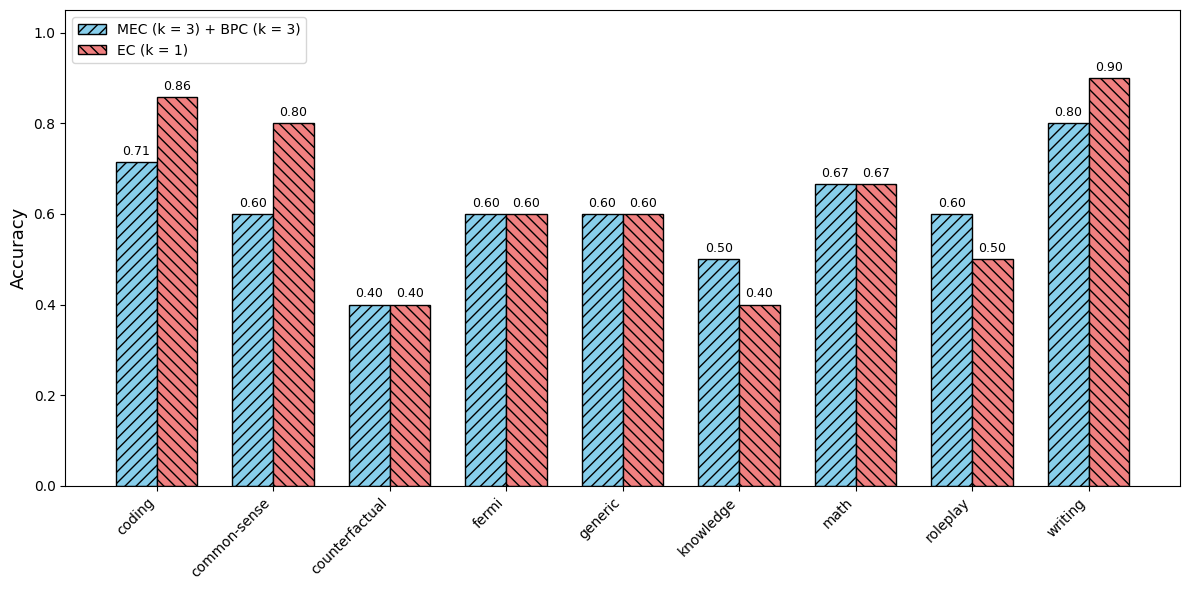

In [479]:
plot_grouped_accuracy_bars(gpt4_best_category_acc, gpt4_worst_category_acc, second_label="EC (k = 1)",
                           first_label='MEC (k = 3) + BPC (k = 3)')

![Paper results](./fig/gpt4_categories.png)

## GPT 3.5
Calculate the accuracy across categories for GPT 3.5

In [480]:
gpt3_5_best_category_acc = judgement_result[f"gpt35_{BEST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt3_5_best_category_acc

category
coding            0.857143
common-sense      0.600000
counterfactual    0.500000
fermi             0.400000
generic           0.600000
knowledge         0.600000
math              0.666667
roleplay          0.500000
writing           0.800000
Name: result_hit, dtype: float64

In [481]:
gpt3_5_worst_category_acc = judgement_result[f"gpt35_{WORST_PARAMETERS_SET}"].groupby('category')['result_hit'].mean()

gpt3_5_worst_category_acc

category
coding            0.857143
common-sense      0.700000
counterfactual    0.500000
fermi             0.600000
generic           0.600000
knowledge         0.600000
math              1.000000
roleplay          0.500000
writing           0.700000
Name: result_hit, dtype: float64

Plot the same chart as in the paper

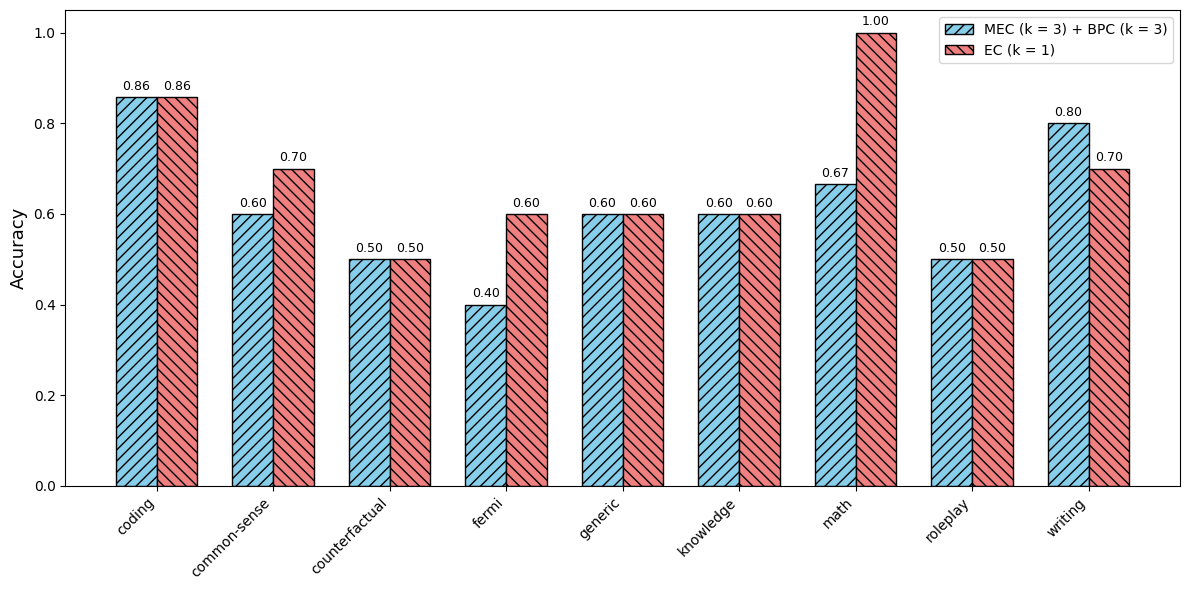

In [482]:
plot_grouped_accuracy_bars(gpt3_5_best_category_acc, gpt3_5_worst_category_acc, second_label="EC (k = 1)",
                           first_label='MEC (k = 3) + BPC (k = 3)')

![Paper results](./fig/gpt3_5_categories.png)

# Sampled results

## Check mean accuracy and kappa coefficient

Find all the directories names 

In [483]:
SAMPLED_RESULTS_PATH = "./sampled_review"

In [484]:
dirs = [int(name) for name in os.listdir(SAMPLED_RESULTS_PATH) if
        os.path.isdir(os.path.join(SAMPLED_RESULTS_PATH, name))]
dirs.sort()
dirs.pop()
dirs

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46]

In [485]:
sampled_result_list = []

for it in range(1, 41):
    current_judgement_result = {
        'gpt35_k_1_bpc_0_t_1': pd.read_json(f'./0_t_ec/{it}/review_gpt35_vicuna_gpt-3.5-turbo_mec1_bpc0.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt4_k_1_bpc_0_t_1': pd.read_json(f'./0_t_ec/{it}/review_gpt35_vicuna_gpt-4_mec1_bpc0.jsonl',
                                           lines=True).set_index(
            'question_id'),
        'gpt35_k_3_bpc_1_t_1': pd.read_json(f'./sampled_review/{it}/review_gpt35_vicuna_gpt-3.5-turbo_mec3_bpc1.jsonl',
                                            lines=True).set_index(
            'question_id'),
        'gpt4_k_3_bpc_1_t_1': pd.read_json(f'./sampled_review/{it}/review_gpt35_vicuna_gpt-4_mec3_bpc1.jsonl',
                                           lines=True).set_index(
            'question_id'),
    }

    sampled_result_list.append(current_judgement_result)

sampled_result_list[0]['gpt4_k_3_bpc_1_t_1']

,question,review,review_bpc,cost,score
question_id,,,,,
5,Can you explain the basics of quantum computing?,[Evaluation evidence: Both assistants provided...,[Evaluation evidence: Both assistants effectiv...,0.10722,"[8.75, 9.666666666666666]"
14,How do language and cultural barriers affect t...,[Evaluation evidence: Both assistants provided...,[Evaluation evidence: Both assistants provided...,0.09276,"[8.5, 9.666666666666666]"
29,"As a space colonist on Mars, describe your dai...",[Evaluation evidence: Both Assistants have pro...,[Evaluation evidence: Both assistants provided...,0.12096,"[9.333333333333334, 8.916666666666666]"
37,Why do some people enjoy the sensation of bein...,[Evaluation evidence: Both assistants provided...,[Evaluation evidence: Both responses are preci...,0.08526,"[8.666666666666666, 9.666666666666666]"
47,How many snowflakes fall during a typical wint...,[Evaluation evidence: Both assistants provided...,[Evaluation evidence: Both Assistant 1 and Ass...,0.11928,"[8.583333333333334, 8.416666666666666]"
56,What if Alan Turing had not cracked the Enigma...,[Evaluation evidence: Both the assistants did ...,[Evaluation evidence: Both assistants provided...,0.09318,"[9.916666666666666, 9.416666666666666]"
63,Implement a regular expression in Python to va...,[Evaluation evidence: Both assistants provided...,[Evaluation evidence: Both Assistant 1 and Ass...,0.09354,"[9.5, 8.833333333333334]"
69,Solve for x in the equation 3x + 10 = 5(x - 2).,[Evaluation evidence: Assistant 1 provided a s...,[Evaluation evidence: Assistant 1's response i...,0.08904,"[10.0, 1.5]"
77,Compose an engaging travel blog post about a r...,[Evaluation evidence: Both Assistant 1 and Ass...,[Evaluation evidence: Both assistants provided...,0.13308,"[9.5, 9.916666666666666]"


In [486]:
for key in sampled_result_list[0].keys():
    for res in sampled_result_list:
        res[key] = res[key].apply(lambda row: extract_result(row, text_lines), axis=1)

sampled_result_list[2]['gpt4_k_1_bpc_0_t_1']

,question,review,review_bpc,cost,score,result,ground_truth,result_hit
question_id,,,,,,,,
7,How can I develop my critical thinking skills?,[Evaluation evidence: Both assistants provided...,[],0.03177,"[9.0, 10.0]",VICUNA13B,CHATGPT,False
17,How do vaccinations work to protect individual...,[Evaluation evidence: Both assistants provided...,[],0.02817,"[9.0, 10.0]",VICUNA13B,VICUNA13B,True
27,Pretend to be a world-famous chef. How would y...,[Evaluation evidence: Both assistants provided...,[],0.03441,"[9.0, 8.0]",CHATGPT,CHATGPT,True
38,How can observing the behavior of other people...,[Evaluation evidence: Both assistants provided...,[],0.02889,"[10.0, 8.0]",CHATGPT,CHATGPT,True
45,How many text messages are sent globally in a ...,[Evaluation evidence: Assistant 1 provided a d...,[],0.03018,"[9.0, 6.0]",CHATGPT,CHATGPT,True
57,What if the Suez Canal had never been construc...,[Evaluation evidence: Both assistants provided...,[],0.02751,"[8.0, 9.0]",VICUNA13B,VICUNA13B,True
66,Implement a queue data structure using two sta...,[Evaluation evidence: Assistant 1 provided a c...,[],0.03570,"[10.0, 2.0]",CHATGPT,CHATGPT,True
69,Solve for x in the equation 3x + 10 = 5(x - 2).,[Evaluation evidence: Assistant 1 provided a c...,[],0.02874,"[10.0, 2.0]",CHATGPT,CHATGPT,True
76,Write a script for a YouTube video exploring t...,[Evaluation evidence: Both assistants provided...,[],0.03771,"[9.0, 8.0]",CHATGPT,CHATGPT,True


In [487]:
sampled_accuracy_map = {}
sampled_kappa_map = {}
sampled_f1_map = {}

sampled_acc_list = {}
sampled_kappa_list = {}

for key in sampled_result_list[0].keys():
    current_result = list(map(lambda x: x[key], sampled_result_list))
    sampled_accuracy_map[key], sampled_kappa_map[key], sampled_f1_map[key], sampled_acc_list[key], sampled_kappa_list[key], _= gather_final_metrics(current_result)

sampled_accuracy_map

{'gpt35_k_1_bpc_0_t_1': np.float64(44.166666666666664),
 'gpt4_k_1_bpc_0_t_1': np.float64(88.33333333333334),
 'gpt35_k_3_bpc_1_t_1': np.float64(79.44444444444444),
 'gpt4_k_3_bpc_1_t_1': np.float64(46.94444444444444)}

In [488]:
gpt_4_tester_acc = TwoSampleStatisticalTests(sampled_acc_list['gpt4_k_3_bpc_1_t_1'], sampled_acc_list['gpt4_k_1_bpc_0_t_1'], )
gpt_4_tester_kappa = TwoSampleStatisticalTests(sampled_kappa_list['gpt4_k_3_bpc_1_t_1'], sampled_kappa_list['gpt4_k_1_bpc_0_t_1'])

print("ACC")
gpt_4_tester_acc.test_two_numerical_samples(is_one_tailed=True)

print("KAPPA")
gpt_4_tester_kappa.test_two_numerical_samples(is_one_tailed=True)

ACC
The result of the p-value when checking the normality for the first dataset: 8.268180079220535e-05
The result of the p-value when checking the normality for the second dataset: 3.2512410563000877e-13
The result of the p-value when checking the variance uniform: 1.0646977938864353e-05
Mann-Whitney was chosen
Final p-value: 0.9999999999999999
H0 was not rejected
KAPPA
The result of the p-value when checking the normality for the first dataset: 0.0011599938206141908
The result of the p-value when checking the normality for the second dataset: 3.569372791683109e-13
The result of the p-value when checking the variance uniform: 6.875942870679636e-07
Mann-Whitney was chosen
Final p-value: 0.9999999999999999
H0 was not rejected


In [489]:
gpt_35_tester_acc = TwoSampleStatisticalTests(sampled_acc_list['gpt35_k_3_bpc_1_t_1'], sampled_acc_list['gpt35_k_1_bpc_0_t_1'])
gpt_35_tester_kappa = TwoSampleStatisticalTests(sampled_kappa_list['gpt35_k_3_bpc_1_t_1'], sampled_kappa_list['gpt35_k_1_bpc_0_t_1'])

print("ACC")
gpt_35_tester_acc.test_two_numerical_samples(is_one_tailed=True)

print("KAPPA")
gpt_35_tester_kappa.test_two_numerical_samples(is_one_tailed=True)

ACC
The result of the p-value when checking the normality for the first dataset: 5.977871270659952e-07
The result of the p-value when checking the normality for the second dataset: 1.1298991811008934e-05
The result of the p-value when checking the variance uniform: 0.11756183162228954
Mann-Whitney was chosen
Final p-value: 1.28089233092466e-15
H0 has been rejected, Ha has been accepted
KAPPA
The result of the p-value when checking the normality for the first dataset: 1.445952369266414e-05
The result of the p-value when checking the normality for the second dataset: 0.0788885637852628
The result of the p-value when checking the variance uniform: 0.008771681577263369
Mann-Whitney was chosen
Final p-value: 4.867435269562136e-15
H0 has been rejected, Ha has been accepted


In [490]:
SAMPLED_DESCRIPTION_MAP = {
    'gpt35_k_1_bpc_0_t_1': {
        'judge': 'GPT-3.5',
        'description': 'EC (k = 1)'
    },
    'gpt4_k_1_bpc_0_t_1': {
        'judge': 'GPT-4',
        'description': 'EC (k = 1)'
    },
    'gpt35_k_3_bpc_1_t_1': {
        'judge': 'GPT-3.5 + MEC + BPC',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
    'gpt4_k_3_bpc_1_t_1': {
        'judge': 'GPT-4 + MEC + BPC',
        'description': 'MEC (k = 3) + BPC (k = 3)'
    },
}

In [491]:
final_table = pd.DataFrame({
    "judge": [v["judge"] for v in SAMPLED_DESCRIPTION_MAP.values()],
    "description": [v["description"] for v in SAMPLED_DESCRIPTION_MAP.values()],
    "accuracy": sampled_accuracy_map.values(),
    "kappa": sampled_kappa_map.values(),
    "F1": sampled_f1_map.values(),
}, index=sampled_accuracy_map.keys())

final_table

,judge,description,accuracy,kappa,F1
gpt35_k_1_bpc_0_t_1,GPT-3.5,EC (k = 1),44.166667,0.066273,0.307786
gpt4_k_1_bpc_0_t_1,GPT-4,EC (k = 1),88.333333,0.716802,0.843932
gpt35_k_3_bpc_1_t_1,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),79.444444,0.639853,0.584328
gpt4_k_3_bpc_1_t_1,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),46.944444,0.124227,0.347262


![Paper results](./fig/first_experiment.png)

# Accuracy distribution around the categories

In [492]:
sampled_question = {
    'gpt35_k_1_bpc_0_t_1': pd.read_json("./sampled/questions/0.jsonl", lines=True),
    'gpt4_k_1_bpc_0_t_1': pd.read_json("./sampled/questions/1.jsonl", lines=True),
    'gpt35_k_3_bpc_1_t_1': pd.read_json("./sampled/questions/2.jsonl", lines=True),
    'gpt4_k_3_bpc_1_t_1': pd.read_json("./sampled/questions/3.jsonl", lines=True)
}

sampled_question['gpt35_k_1_bpc_0_t_1']

,question_id,text,category
0,5,Can you explain the basics of quantum computing?,generic
1,11,What are some potential implications of using ...,knowledge
2,28,You are a mountain climber reaching the summit...,roleplay
3,34,How can you determine if a person is genuinely...,common-sense
4,43,How many lightning strikes occur on Earth each...,fermi
5,53,What if the Black Death had not occurred in th...,counterfactual
6,64,Write a program to find the nth Fibonacci numb...,coding
7,70,"If the endpoints of a line segment are (2, -2)...",math
8,80,"Write a symphony concert review, discussing th...",writing


In [493]:
topic_comparison_base = {}

for key in sampled_question.keys():
    key_name = SAMPLED_DESCRIPTION_MAP[key]['judge']

    if key_name not in topic_comparison_base:
        topic_comparison_base[key_name] = {}
    for category in sampled_question['gpt35_k_1_bpc_0_t_1']['category'].unique():
        topic_comparison_base[key_name][category] = 0

topic_comparison_table = pd.DataFrame(topic_comparison_base)
topic_comparison_table

,GPT-3.5,GPT-4,GPT-3.5 + MEC + BPC,GPT-4 + MEC + BPC
generic,0,0,0,0
knowledge,0,0,0,0
roleplay,0,0,0,0
common-sense,0,0,0,0
fermi,0,0,0,0
counterfactual,0,0,0,0
coding,0,0,0,0
math,0,0,0,0
writing,0,0,0,0


In [494]:
def process_row(row, comp_table, feature_name):
    comp_table.at[row['category'], feature_name] += 1 if row['result_hit'] else 0


for sample in sampled_result_list:
    for key in sample.keys():
        current_df = sample[key]
        current_questions = sampled_question[key]

        feature_name = SAMPLED_DESCRIPTION_MAP[key]['judge']

        merged_df = pd.merge(current_df, current_questions, left_index=True, right_on="question_id")
        merged_df.apply(lambda row: process_row(row, topic_comparison_table, feature_name), axis=1)

topic_comparison_table

,GPT-3.5,GPT-4,GPT-3.5 + MEC + BPC,GPT-4 + MEC + BPC
generic,21,0,39,40
knowledge,2,40,40,0
roleplay,0,39,12,0
common-sense,0,40,40,40
fermi,40,40,40,19
counterfactual,2,39,2,1
coding,37,40,39,24
math,40,40,40,40
writing,17,40,34,5


In [495]:
topic_comparison_table = topic_comparison_table / 40 * 100
topic_comparison_table = topic_comparison_table.applymap(lambda x: f"{x}%" if pd.notnull(x) else "")
topic_comparison_table

/var/folders/1r/q7sz92cx6mvgt9xkk4_68cn00000gn/T/ipykernel_24636/3098987464.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  topic_comparison_table = topic_comparison_table.applymap(lambda x: f"{x}%" if pd.notnull(x) else "")


,GPT-3.5,GPT-4,GPT-3.5 + MEC + BPC,GPT-4 + MEC + BPC
generic,52.5%,0.0%,97.5%,100.0%
knowledge,5.0%,100.0%,100.0%,0.0%
roleplay,0.0%,97.5%,30.0%,0.0%
common-sense,0.0%,100.0%,100.0%,100.0%
fermi,100.0%,100.0%,100.0%,47.5%
counterfactual,5.0%,97.5%,5.0%,2.5%
coding,92.5%,100.0%,97.5%,60.0%
math,100.0%,100.0%,100.0%,100.0%
writing,42.5%,100.0%,85.0%,12.5%


# CascadeEval extraction with GPT-3.5

In [496]:
vicuna_vanilla_questions = pd.read_json('./vicuna/vanilla-vicuna.json')
vicuna_vanilla_questions['ground_truth'] = vicuna_vanilla_questions['question_id'].apply(lambda x: text_lines[x - 1])
vicuna_vanilla_questions = vicuna_vanilla_questions.set_index('question_id')

vicuna_vanilla_questions

,text_vicuna,text_gpt,question_text,category,ground_truth
question_id,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,VICUNA13B
11,Using a single-use plastic bottle versus a reu...,Using a single-use plastic bottle has negative...,What are some potential implications of using ...,knowledge,TIE
28,"As a language model AI, I don't have personal ...","I'm sorry, but as an AI language model, I am n...",You are a mountain climber reaching the summit...,roleplay,CHATGPT
34,It can be difficult to determine if a person i...,There are several ways to determine if a perso...,How can you determine if a person is genuinely...,common-sense,TIE
43,It is difficult to give an exact number of how...,"According to research, it is estimated that th...",How many lightning strikes occur on Earth each...,fermi,CHATGPT
53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,TIE
64,Here is an example of a program in Python that...,Certainly! Here's an example Python program us...,Write a program to find the nth Fibonacci numb...,coding,CHATGPT
70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,CHATGPT
80,"The concert was a true spectacle of sound, fea...",I'm happy to assist you in writing a symphony ...,"Write a symphony concert review, discussing th...",writing,CHATGPT


In [497]:
cascaded_eval_result_list = []

for i in range(1, 47):
    with open(f'./cascaded-eval-results/vicuna/{i}-auto-j-vicuna-final.json', "r") as f:
        auto_j_results = json.loads(f.read().strip())

    with open(f'./relia_scores/auto-j/vicuna/{i}-relia.json', "r") as f:
        auto_j_top_indices = get_top_half_indices(json.loads(f.read().strip())['Entropy'])

    with open(f'./cascaded-eval-results/vicuna/{i}-judgelm-vicuna-final.json', "r") as f:
        judgelm_results = json.loads(f.read().strip())

    with open(f'./relia_scores/judgelm/vicuna/{i}-relia.json', "r") as f:
        judgelm_top_indices = get_top_half_indices(json.loads(f.read().strip())['Entropy'])

    auto_j = vicuna_vanilla_questions.copy()
    auto_j['score'] = auto_j_results

    judgelm = vicuna_vanilla_questions.copy()
    judgelm['score'] = judgelm_results

    current_judgement_result = {
        'auto-j': auto_j,
        'judgelm': judgelm,
    }
    cascaded_eval_result_list.append(current_judgement_result)

cascaded_eval_result_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,VICUNA13B,"[0, 1]"
11,Using a single-use plastic bottle versus a reu...,Using a single-use plastic bottle has negative...,What are some potential implications of using ...,knowledge,TIE,"[9.0, 8.0]"
28,"As a language model AI, I don't have personal ...","I'm sorry, but as an AI language model, I am n...",You are a mountain climber reaching the summit...,roleplay,CHATGPT,"[0, 1]"
34,It can be difficult to determine if a person i...,There are several ways to determine if a perso...,How can you determine if a person is genuinely...,common-sense,TIE,"[0, 1]"
43,It is difficult to give an exact number of how...,"According to research, it is estimated that th...",How many lightning strikes occur on Earth each...,fermi,CHATGPT,"[1, 0]"
53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,TIE,"[8.0, 7.0]"
64,Here is an example of a program in Python that...,Certainly! Here's an example Python program us...,Write a program to find the nth Fibonacci numb...,coding,CHATGPT,"[9.0, 5.0]"
70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,CHATGPT,"[9.0, 6.0]"
80,"The concert was a true spectacle of sound, fea...",I'm happy to assist you in writing a symphony ...,"Write a symphony concert review, discussing th...",writing,CHATGPT,"[9.0, 8.0]"


In [498]:
for key in cascaded_eval_result_list[0].keys():
    for res in cascaded_eval_result_list:
        res[key] = res[key].apply(lambda row: extract_result(row, text_lines), axis=1)

cascaded_eval_result_list[5]['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score,result,result_hit
question_id,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,VICUNA13B,"[0, 1]",VICUNA13B,True
11,Using a single-use plastic bottle versus a reu...,Using a single-use plastic bottle has negative...,What are some potential implications of using ...,knowledge,TIE,"[8.0, 6.0]",CHATGPT,False
28,"As a language model AI, I don't have personal ...","I'm sorry, but as an AI language model, I am n...",You are a mountain climber reaching the summit...,roleplay,CHATGPT,"[0, 1]",VICUNA13B,False
34,It can be difficult to determine if a person i...,There are several ways to determine if a perso...,How can you determine if a person is genuinely...,common-sense,TIE,"[0, 1]",VICUNA13B,False
43,It is difficult to give an exact number of how...,"According to research, it is estimated that th...",How many lightning strikes occur on Earth each...,fermi,CHATGPT,"[1, 0]",CHATGPT,True
53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,TIE,"[8.0, 6.0]",CHATGPT,False
64,Here is an example of a program in Python that...,Certainly! Here's an example Python program us...,Write a program to find the nth Fibonacci numb...,coding,CHATGPT,"[9.0, 6.0]",CHATGPT,True
70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,CHATGPT,"[9.0, 5.0]",CHATGPT,True
80,"The concert was a true spectacle of sound, fea...",I'm happy to assist you in writing a symphony ...,"Write a symphony concert review, discussing th...",writing,CHATGPT,"[9.0, 8.0]",CHATGPT,True


In [499]:
cascaded_accuracy_map = {}
cascaded_kappa_map = {}
cascaded_f1_map = {}

for key in cascaded_eval_result_list[0].keys():
    current_result = list(map(lambda x: x[key], cascaded_eval_result_list))
    cascaded_accuracy_map[key], cascaded_kappa_map[key], cascaded_f1_map[key], _, _, _ = gather_final_metrics(current_result)

cascaded_accuracy_map

{'auto-j': np.float64(50.96618357487922),
 'judgelm': np.float64(56.763285024154605)}

In [500]:
CASCADED_DESCRIPTION_MAP = {
    'auto-j': {
        'judge': 'Auto-J (CascadedEval with GPT-3.5)',
        'description': 'CascadedEval + EC (k = 1) + GPT-3.5'
    },
    'judgelm': {
        'judge': 'JudgeLM (CascadedEval with GPT-3.5)',
        'description': 'CascadedEval + EC (k = 1) + GPT-3.5'
    },
}

In [501]:
cascaded_final_table = pd.DataFrame({
    "judge": [v["judge"] for v in CASCADED_DESCRIPTION_MAP.values()],
    "description": [v["description"] for v in CASCADED_DESCRIPTION_MAP.values()],
    "accuracy": cascaded_accuracy_map.values(),
    "kappa": cascaded_kappa_map.values(),
    "F1": cascaded_f1_map.values(),
}, index=cascaded_accuracy_map.keys())

cascaded_final_table = pd.concat([cascaded_final_table, final_table], ignore_index=True)
cascaded_final_table

,judge,description,accuracy,kappa,F1
0,Auto-J (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,50.966184,0.211477,0.401464
1,JudgeLM (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,56.763285,0.216264,0.392710
2,GPT-3.5,EC (k = 1),44.166667,0.066273,0.307786
3,GPT-4,EC (k = 1),88.333333,0.716802,0.843932
4,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),79.444444,0.639853,0.584328
5,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),46.944444,0.124227,0.347262


# MEC with CascadedEval extraction with GPT-3.5

In [502]:
vicuna_mec_questions = pd.read_json('./vicuna/mec-bpc-vicuna.json')
vicuna_mec_questions['ground_truth'] = vicuna_mec_questions['question_id'].apply(lambda x: text_lines[x - 1])
vicuna_mec_questions = vicuna_mec_questions.set_index('question_id')

vicuna_mec_questions

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B


In [503]:
mec_cascaded_eval_result_list = []

for i in range(1, 47):
    with open(f'./cascaded-eval-results/vicuna-mec/{i}-auto-j-vicuna-mec-final.json', "r") as f:
        auto_j_results = json.loads(f.read().strip())

    with open(f'./cascaded-eval-results/vicuna-mec/{i}-judgelm-vicuna-mec-final.json', "r") as f:
        judgelm_results = json.loads(f.read().strip())

    auto_j = vicuna_mec_questions.copy()
    auto_j['score'] = auto_j_results

    judgelm = vicuna_mec_questions.copy()
    judgelm['score'] = judgelm_results

    current_judgement_result = {
        'auto-j': auto_j,
        'judgelm': judgelm,
    }

    mec_cascaded_eval_result_list.append(current_judgement_result)

mec_cascaded_eval_result_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score
question_id,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]"
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]"
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]"


In [504]:
for key in mec_cascaded_eval_result_list[0].keys():
    for res in mec_cascaded_eval_result_list:
        res[key] = res[key].apply(reverse_row, axis=1)

mec_cascaded_eval_result_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score
question_id,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]"
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]"
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]"
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]"


In [505]:
for key in mec_cascaded_eval_result_list[0].keys():
    for res in mec_cascaded_eval_result_list:
        res[key] = res[key].apply(lambda row: extract_result(row, text_lines), axis=1)

mec_cascaded_eval_result_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,result,result_hit
question_id,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]",VICUNA13B,True
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",VICUNA13B,True
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",VICUNA13B,True
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",VICUNA13B,True


In [506]:
for current_eval_result in mec_cascaded_eval_result_list:
    for key, value in current_eval_result.items():
        value = value.groupby('question_id').agg({
            'result': lambda x: x.value_counts().idxmax(),
            'ground_truth': 'first',
        })

        value['result_hit'] = value['result'] == value['ground_truth']

        current_eval_result[key] = value

mec_cascaded_eval_result_list[0]['auto-j']

,result,ground_truth,result_hit
question_id,,,
5,VICUNA13B,VICUNA13B,True
18,VICUNA13B,VICUNA13B,True
26,CHATGPT,CHATGPT,True
40,VICUNA13B,VICUNA13B,True
45,CHATGPT,CHATGPT,True
53,VICUNA13B,TIE,False
63,VICUNA13B,VICUNA13B,True
70,CHATGPT,CHATGPT,True
76,CHATGPT,CHATGPT,True


In [507]:
mec_cascaded_accuracy_map = {}
mec_cascaded_kappa_map = {}
mec_cascaded_f1_map = {}

mec_cascaded_accuracy_list = {}
mec_cascaded_kappa_list = {}

for key in mec_cascaded_eval_result_list[0].keys():
    current_result = list(map(lambda x: x[key], mec_cascaded_eval_result_list))
    mec_cascaded_accuracy_map[key], mec_cascaded_kappa_map[key], mec_cascaded_f1_map[key], mec_cascaded_accuracy_list[key], mec_cascaded_kappa_list[key], _ = gather_final_metrics(
        current_result)

mec_cascaded_accuracy_map

{'auto-j': np.float64(83.09178743961351),
 'judgelm': np.float64(54.10628019323672)}

In [508]:
MEC_CASCADED_DESCRIPTION_MAP = {
    'auto-j': {
        'judge': 'Auto-J (CascadedEval with GPT-3.5) + MEC + BPC',
        'description': 'CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-3.5'
    },
    'judgelm': {
        'judge': 'JudgeLM (CascadedEval with GPT-3.5) + MEC + BPC',
        'description': 'CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-3.5'
    },
}

In [509]:
mec_cascaded_final_table = pd.DataFrame({
    "judge": [v["judge"] for v in MEC_CASCADED_DESCRIPTION_MAP.values()],
    "description": [v["description"] for v in MEC_CASCADED_DESCRIPTION_MAP.values()],
    "accuracy": mec_cascaded_accuracy_map.values(),
    "kappa": mec_cascaded_kappa_map.values(),
    "F1": mec_cascaded_f1_map.values(),
}, index=mec_cascaded_accuracy_map.keys())

mec_cascaded_final_table = pd.concat([mec_cascaded_final_table, cascaded_final_table], ignore_index=True)
mec_cascaded_final_table

,judge,description,accuracy,kappa,F1
0,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,83.091787,0.697283,0.590892
1,JudgeLM (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,54.106280,0.227941,0.403589
2,Auto-J (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,50.966184,0.211477,0.401464
3,JudgeLM (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,56.763285,0.216264,0.392710
4,GPT-3.5,EC (k = 1),44.166667,0.066273,0.307786
5,GPT-4,EC (k = 1),88.333333,0.716802,0.843932
6,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),79.444444,0.639853,0.584328
7,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),46.944444,0.124227,0.347262


# CascadeEval extraction with GPT-4

In [510]:
vicuna_vanilla_questions_gpt4 = pd.read_json('./vicuna/vanilla-vicuna-gpt4.json')
vicuna_vanilla_questions_gpt4['ground_truth'] = vicuna_vanilla_questions_gpt4['question_id'].apply(
    lambda x: text_lines[x - 1])
vicuna_vanilla_questions_gpt4 = vicuna_vanilla_questions_gpt4.set_index('question_id')

vicuna_vanilla_questions_gpt4

,text_vicuna,text_gpt,question_text,category,ground_truth
question_id,,,,,
7,Developing your critical thinking skills can h...,"Sure, here are a few practical tips to develop...",How can I develop my critical thinking skills?,generic,CHATGPT
17,"Vaccinations work by introducing a small, harm...",Vaccinations work by introducing a weakened or...,How do vaccinations work to protect individual...,knowledge,VICUNA13B
27,"Ladies and gentlemen, my name is [Chef's Name]...","Welcome, esteemed judges. I'm excited to prese...",Pretend to be a world-famous chef. How would y...,roleplay,CHATGPT
38,Observing the behavior of other people in a so...,Observing the behavior of other people in a so...,How can observing the behavior of other people...,common-sense,CHATGPT
45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,CHATGPT
57,The Suez Canal is a man-made waterway that con...,"If the Suez Canal had never been constructed, ...",What if the Suez Canal had never been construc...,counterfactual,VICUNA13B
66,Here is an implementation of a queue using two...,Here's an example implementation of a queue us...,Implement a queue data structure using two sta...,coding,CHATGPT
69,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,CHATGPT
76,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,CHATGPT


In [511]:
cascaded_eval_result_list_gpt4 = []

for i in range(1, 47):
    with open(f'./cascaded-eval-results/vicuna-gpt4/{i}-auto-j-vicuna-gpt4-final.json', "r") as f:
        auto_j_results = json.loads(f.read().strip())

    with open(f'./cascaded-eval-results/vicuna-gpt4/{i}-judgelm-vicuna-gpt4-final.json', "r") as f:
        judgelm_results = json.loads(f.read().strip())

    auto_j = vicuna_vanilla_questions_gpt4.copy()
    auto_j['score'] = auto_j_results

    judgelm = vicuna_vanilla_questions_gpt4.copy()
    judgelm['score'] = judgelm_results

    current_judgement_result = {
        'auto-j': auto_j,
        'judgelm': judgelm,
    }

    cascaded_eval_result_list_gpt4.append(current_judgement_result)

cascaded_eval_result_list_gpt4[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score
question_id,,,,,,
7,Developing your critical thinking skills can h...,"Sure, here are a few practical tips to develop...",How can I develop my critical thinking skills?,generic,CHATGPT,"[0, 1]"
17,"Vaccinations work by introducing a small, harm...",Vaccinations work by introducing a weakened or...,How do vaccinations work to protect individual...,knowledge,VICUNA13B,"[0, 1]"
27,"Ladies and gentlemen, my name is [Chef's Name]...","Welcome, esteemed judges. I'm excited to prese...",Pretend to be a world-famous chef. How would y...,roleplay,CHATGPT,"[9.0, 8.0]"
38,Observing the behavior of other people in a so...,Observing the behavior of other people in a so...,How can observing the behavior of other people...,common-sense,CHATGPT,"[10.0, 9.0]"
45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,CHATGPT,"[1, 0]"
57,The Suez Canal is a man-made waterway that con...,"If the Suez Canal had never been constructed, ...",What if the Suez Canal had never been construc...,counterfactual,VICUNA13B,"[0, 1]"
66,Here is an implementation of a queue using two...,Here's an example implementation of a queue us...,Implement a queue data structure using two sta...,coding,CHATGPT,"[10.0, 2.0]"
69,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,CHATGPT,"[10.0, 2.0]"
76,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,CHATGPT,"[9.0, 8.5]"


In [512]:
for key in cascaded_eval_result_list_gpt4[0].keys():
    for res in cascaded_eval_result_list_gpt4:
        res[key] = res[key].apply(lambda row: extract_result(row, text_lines), axis=1)

cascaded_eval_result_list_gpt4[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,ground_truth,score,result,result_hit
question_id,,,,,,,,
7,Developing your critical thinking skills can h...,"Sure, here are a few practical tips to develop...",How can I develop my critical thinking skills?,generic,CHATGPT,"[0, 1]",VICUNA13B,False
17,"Vaccinations work by introducing a small, harm...",Vaccinations work by introducing a weakened or...,How do vaccinations work to protect individual...,knowledge,VICUNA13B,"[0, 1]",VICUNA13B,True
27,"Ladies and gentlemen, my name is [Chef's Name]...","Welcome, esteemed judges. I'm excited to prese...",Pretend to be a world-famous chef. How would y...,roleplay,CHATGPT,"[9.0, 8.0]",CHATGPT,True
38,Observing the behavior of other people in a so...,Observing the behavior of other people in a so...,How can observing the behavior of other people...,common-sense,CHATGPT,"[10.0, 9.0]",CHATGPT,True
45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,CHATGPT,"[1, 0]",CHATGPT,True
57,The Suez Canal is a man-made waterway that con...,"If the Suez Canal had never been constructed, ...",What if the Suez Canal had never been construc...,counterfactual,VICUNA13B,"[0, 1]",VICUNA13B,True
66,Here is an implementation of a queue using two...,Here's an example implementation of a queue us...,Implement a queue data structure using two sta...,coding,CHATGPT,"[10.0, 2.0]",CHATGPT,True
69,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,math,CHATGPT,"[10.0, 2.0]",CHATGPT,True
76,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,CHATGPT,"[9.0, 8.5]",CHATGPT,True


In [513]:
cascaded_accuracy_map_gpt4 = {}
cascaded_kappa_map_gpt4 = {}
cascaded_f1_map_gpt4 = {}

for key in cascaded_eval_result_list_gpt4[0].keys():
    current_result = list(map(lambda x: x[key], cascaded_eval_result_list_gpt4))
    cascaded_accuracy_map_gpt4[key], cascaded_kappa_map_gpt4[key], cascaded_f1_map_gpt4[key], _, _, _ = gather_final_metrics(
        current_result)

cascaded_accuracy_map_gpt4

{'auto-j': np.float64(86.71497584541062),
 'judgelm': np.float64(77.05314009661838)}

In [514]:
CASCADED_DESCRIPTION_GPT4_MAP = {
    'auto-j': {
        'judge': 'Auto-J (CascadedEval with GPT-4)',
        'description': 'CascadedEval + EC (k = 1) + GPT-4'
    },
    'judgelm': {
        'judge': 'JudgeLM (CascadedEval with GPT-4)',
        'description': 'CascadedEval + EC (k = 1) + GPT-4'
    },
}

In [515]:
cascaded_gpt4_table = pd.DataFrame({
    "judge": [v["judge"] for v in CASCADED_DESCRIPTION_GPT4_MAP.values()],
    "description": [v["description"] for v in CASCADED_DESCRIPTION_GPT4_MAP.values()],
    "accuracy": cascaded_accuracy_map_gpt4.values(),
    "kappa": cascaded_kappa_map_gpt4.values(),
    "F1": cascaded_f1_map_gpt4.values(),
}, index=cascaded_accuracy_map_gpt4.keys())

cascaded_gpt4_table = pd.concat([mec_cascaded_final_table, cascaded_gpt4_table], ignore_index=True)
cascaded_gpt4_table

,judge,description,accuracy,kappa,F1
0,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,83.091787,0.697283,0.590892
1,JudgeLM (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,54.106280,0.227941,0.403589
2,Auto-J (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,50.966184,0.211477,0.401464
3,JudgeLM (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,56.763285,0.216264,0.392710
4,GPT-3.5,EC (k = 1),44.166667,0.066273,0.307786
5,GPT-4,EC (k = 1),88.333333,0.716802,0.843932
6,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),79.444444,0.639853,0.584328
7,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),46.944444,0.124227,0.347262
8,Auto-J (CascadedEval with GPT-4),CascadedEval + EC (k = 1) + GPT-4,86.714976,0.692074,0.803967
9,JudgeLM (CascadedEval with GPT-4),CascadedEval + EC (k = 1) + GPT-4,77.053140,0.534627,0.537458


# MEC with CascadedEval extraction with GPT-4

In [516]:
vicuna_mec_questions_gpt4 = pd.read_json('./vicuna/mec-bpc-vicuna-gpt4.json')
vicuna_mec_questions_gpt4['ground_truth'] = vicuna_mec_questions_gpt4['question_id'].apply(lambda x: text_lines[x - 1])
vicuna_mec_questions_gpt4 = vicuna_mec_questions_gpt4.set_index('question_id')

vicuna_mec_questions_gpt4

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE


In [517]:
mec_cascaded_eval_result_gpt4_list = []

for i in range(1, 47):
    with open(f'./cascaded-eval-results/vicuna-mec-gpt4/{i}-auto-j-vicuna-mec-gpt4-final.json', "r") as f:
        auto_j_results = json.loads(f.read().strip())

    with open(f'./cascaded-eval-results/vicuna-mec-gpt4/{i}-judgelm-vicuna-mec-gpt4-final.json', "r") as f:
        judgelm_results = json.loads(f.read().strip())

    auto_j = vicuna_mec_questions_gpt4.copy()
    auto_j['score'] = auto_j_results

    judgelm = vicuna_mec_questions_gpt4.copy()
    judgelm['score'] = judgelm_results

    current_judgement_result = {
        'auto-j': auto_j,
        'judgelm': judgelm,
    }

    mec_cascaded_eval_result_gpt4_list.append(current_judgement_result)

mec_cascaded_eval_result_gpt4_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score
question_id,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]"


In [518]:
for key in mec_cascaded_eval_result_gpt4_list[0].keys():
    for res in mec_cascaded_eval_result_gpt4_list:
        res[key] = res[key].apply(reverse_row, axis=1)

mec_cascaded_eval_result_gpt4_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score
question_id,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]"


In [519]:
for key in mec_cascaded_eval_result_gpt4_list[0].keys():
    for res in mec_cascaded_eval_result_gpt4_list:
        res[key] = res[key].apply(lambda row: extract_result(row, text_lines), axis=1)

mec_cascaded_eval_result_gpt4_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,result,result_hit
question_id,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]",VICUNA13B,True
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",VICUNA13B,False
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",VICUNA13B,False
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,TIE,"[0, 1]",VICUNA13B,False


In [520]:
for current_eval_result in mec_cascaded_eval_result_gpt4_list:
    for key, value in current_eval_result.items():
        value = value.groupby('question_id').agg({
            'result': lambda x: x.value_counts().idxmax(),
            'ground_truth': 'first',
        })

        value['result_hit'] = value['result'] == value['ground_truth']

        current_eval_result[key] = value

mec_cascaded_eval_result_gpt4_list[0]['auto-j']

,result,ground_truth,result_hit
question_id,,,
5,VICUNA13B,VICUNA13B,True
14,VICUNA13B,TIE,False
29,VICUNA13B,VICUNA13B,True
37,VICUNA13B,VICUNA13B,True
47,VICUNA13B,CHATGPT,False
56,CHATGPT,TIE,False
63,CHATGPT,VICUNA13B,False
69,CHATGPT,CHATGPT,True
77,TIE,CHATGPT,False


In [521]:
mec_cascaded_accuracy_gpt4_map = {}
mec_cascaded_kappa_gpt4_map = {}
mec_cascaded_f1_gpt4_map = {}

mec_cascaded_accuracy_gpt4_list = {}
mec_cascaded_kappa_gpt4_list = {}

for key in mec_cascaded_eval_result_gpt4_list[0].keys():
    current_result = list(map(lambda x: x[key], mec_cascaded_eval_result_gpt4_list))
    mec_cascaded_accuracy_gpt4_map[key], mec_cascaded_kappa_gpt4_map[key], mec_cascaded_f1_gpt4_map[
        key], mec_cascaded_accuracy_gpt4_list[key], mec_cascaded_kappa_gpt4_list[key], _ = gather_final_metrics(current_result)

mec_cascaded_accuracy_gpt4_map

{'auto-j': np.float64(49.275362318840564),
 'judgelm': np.float64(58.69565217391303)}

In [522]:
MEC_CASCADED_DESCRIPTION_GPT4_MAP = {
    'auto-j': {
        'judge': 'Auto-J (CascadedEval with GPT-4) + MEC + BPC',
        'description': 'CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4'
    },
    'judgelm': {
        'judge': 'JudgeLM (CascadedEval with GPT-4) + MEC + BPC',
        'description': 'CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4'
    },
}

In [523]:
mec_cascaded_gpt_4table = pd.DataFrame({
    "judge": [v["judge"] for v in MEC_CASCADED_DESCRIPTION_GPT4_MAP.values()],
    "description": [v["description"] for v in MEC_CASCADED_DESCRIPTION_GPT4_MAP.values()],
    "accuracy": mec_cascaded_accuracy_gpt4_map.values(),
    "kappa": mec_cascaded_kappa_gpt4_map.values(),
    "F1": mec_cascaded_f1_gpt4_map.values(),
}, index=mec_cascaded_accuracy_gpt4_map.keys())

mec_cascaded_gpt_4table = pd.concat([mec_cascaded_gpt_4table, cascaded_gpt4_table], ignore_index=True)
mec_cascaded_gpt_4table

,judge,description,accuracy,kappa,F1
0,Auto-J (CascadedEval with GPT-4) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4,49.275362,0.154104,0.354957
1,JudgeLM (CascadedEval with GPT-4) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4,58.695652,0.334435,0.473999
2,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,83.091787,0.697283,0.590892
3,JudgeLM (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,54.106280,0.227941,0.403589
4,Auto-J (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,50.966184,0.211477,0.401464
5,JudgeLM (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,56.763285,0.216264,0.392710
6,GPT-3.5,EC (k = 1),44.166667,0.066273,0.307786
7,GPT-4,EC (k = 1),88.333333,0.716802,0.843932
8,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),79.444444,0.639853,0.584328
9,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),46.944444,0.124227,0.347262


# Final splitting

## GPT-3.5

In [524]:
gpt35_final = mec_cascaded_gpt_4table[mec_cascaded_gpt_4table['judge'].str.contains('GPT-3.5', na=False)]
gpt35_final

,judge,description,accuracy,kappa,F1
2,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,83.091787,0.697283,0.590892
3,JudgeLM (CascadedEval with GPT-3.5) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT...,54.106280,0.227941,0.403589
4,Auto-J (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,50.966184,0.211477,0.401464
5,JudgeLM (CascadedEval with GPT-3.5),CascadedEval + EC (k = 1) + GPT-3.5,56.763285,0.216264,0.392710
6,GPT-3.5,EC (k = 1),44.166667,0.066273,0.307786
8,GPT-3.5 + MEC + BPC,MEC (k = 3) + BPC (k = 3),79.444444,0.639853,0.584328


## GPT-4

In [525]:
gpt4_final = mec_cascaded_gpt_4table[mec_cascaded_gpt_4table['judge'].str.contains('GPT-4', na=False)]
gpt4_final

,judge,description,accuracy,kappa,F1
0,Auto-J (CascadedEval with GPT-4) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4,49.275362,0.154104,0.354957
1,JudgeLM (CascadedEval with GPT-4) + MEC + BPC,CascadedEval + MEC (k = 3) + BPC (k = 3) + GPT-4,58.695652,0.334435,0.473999
7,GPT-4,EC (k = 1),88.333333,0.716802,0.843932
9,GPT-4 + MEC + BPC,MEC (k = 3) + BPC (k = 3),46.944444,0.124227,0.347262
10,Auto-J (CascadedEval with GPT-4),CascadedEval + EC (k = 1) + GPT-4,86.714976,0.692074,0.803967
11,JudgeLM (CascadedEval with GPT-4),CascadedEval + EC (k = 1) + GPT-4,77.053140,0.534627,0.537458


# Statistical testing

In [526]:
gpt_4_acc = sampled_acc_list['gpt4_k_1_bpc_0_t_1']
gpt_4_mec_acc = sampled_acc_list['gpt4_k_3_bpc_1_t_1']
calib_judge_lm_gpt4_acc = mec_cascaded_accuracy_gpt4_list['judgelm']
calib_auto_j_gpt4_acc = mec_cascaded_accuracy_gpt4_list['auto-j']

print("MEC vs baseline")
mec_tester = TwoSampleStatisticalTests(gpt_4_mec_acc, gpt_4_acc)
mec_tester.test_two_numerical_samples()

print("JudgeLM vs MEC")
mec_tester = TwoSampleStatisticalTests(calib_judge_lm_gpt4_acc, gpt_4_mec_acc)
mec_tester.test_two_numerical_samples(is_one_tailed=True)


print("Auto-J vs MEC")
mec_tester = TwoSampleStatisticalTests(gpt_4_mec_acc, calib_auto_j_gpt4_acc)
mec_tester.test_two_numerical_samples()

MEC vs baseline
The result of the p-value when checking the normality for the first dataset: 8.268180079220535e-05
The result of the p-value when checking the normality for the second dataset: 3.2512410563000877e-13
The result of the p-value when checking the variance uniform: 1.0646977938864353e-05
Mann-Whitney was chosen
Final p-value: 1.7316802045099713e-16
H0 has been rejected, Ha has been accepted
JudgeLM vs MEC
The result of the p-value when checking the normality for the first dataset: 4.463494043486819e-05
The result of the p-value when checking the normality for the second dataset: 8.268180079220535e-05
The result of the p-value when checking the variance uniform: 0.6277575704033395
Mann-Whitney was chosen
Final p-value: 5.996836639812117e-08
H0 has been rejected, Ha has been accepted
Auto-J vs MEC
The result of the p-value when checking the normality for the first dataset: 8.268180079220535e-05
The result of the p-value when checking the normality for the second dataset: 0.00

In [527]:
gpt_4_kappa = sampled_kappa_list['gpt4_k_1_bpc_0_t_1']
gpt_4_mec_kappa = sampled_kappa_list['gpt4_k_3_bpc_1_t_1']
calib_judge_lm_gpt4_kappa = mec_cascaded_kappa_gpt4_list['judgelm']
calib_auto_j_gpt4_kappa = mec_cascaded_kappa_gpt4_list['auto-j']

print("MEC vs baseline")
mec_tester = TwoSampleStatisticalTests(gpt_4_mec_kappa, gpt_4_kappa)
mec_tester.test_two_numerical_samples()

print("JudgeLM vs MEC")
mec_tester = TwoSampleStatisticalTests(calib_judge_lm_gpt4_kappa, gpt_4_mec_kappa)
mec_tester.test_two_numerical_samples(is_one_tailed=True)

print("Auto-J vs MEC")
mec_tester = TwoSampleStatisticalTests(gpt_4_mec_kappa, calib_auto_j_gpt4_kappa)
mec_tester.test_two_numerical_samples()

MEC vs baseline
The result of the p-value when checking the normality for the first dataset: 0.0011599938206141908
The result of the p-value when checking the normality for the second dataset: 3.569372791683109e-13
The result of the p-value when checking the variance uniform: 6.875942870679636e-07
Mann-Whitney was chosen
Final p-value: 3.0062725535089836e-16
H0 has been rejected, Ha has been accepted
JudgeLM vs MEC
The result of the p-value when checking the normality for the first dataset: 0.0008171712808802121
The result of the p-value when checking the normality for the second dataset: 0.0011599938206141908
The result of the p-value when checking the variance uniform: 0.765572900146692
Mann-Whitney was chosen
Final p-value: 1.7285341079224916e-09
H0 has been rejected, Ha has been accepted
Auto-J vs MEC
The result of the p-value when checking the normality for the first dataset: 0.0011599938206141908
The result of the p-value when checking the normality for the second dataset: 0.0020

In [528]:
gpt_35_acc = sampled_acc_list['gpt35_k_1_bpc_0_t_1']
gpt_35_mec_acc = sampled_acc_list['gpt35_k_3_bpc_1_t_1']
calib_judge_lm_gpt35_acc = mec_cascaded_accuracy_list['judgelm']
calib_auto_j_gpt35_acc = mec_cascaded_accuracy_list['auto-j']

print("MEC vs baseline")
mec_tester = TwoSampleStatisticalTests(gpt_35_mec_acc, gpt_35_acc)
mec_tester.test_two_numerical_samples(is_one_tailed=True)

print("JudgeLM vs MEC")
mec_tester = TwoSampleStatisticalTests(calib_judge_lm_gpt35_acc, gpt_35_mec_acc)
mec_tester.test_two_numerical_samples()
print(calib_judge_lm_gpt35_acc.mean())
print(gpt_35_mec_acc.mean())

print("Auto-J vs MEC")
mec_tester = TwoSampleStatisticalTests(calib_auto_j_gpt35_acc, gpt_35_mec_acc)
mec_tester.test_two_numerical_samples()

MEC vs baseline
The result of the p-value when checking the normality for the first dataset: 5.977871270659952e-07
The result of the p-value when checking the normality for the second dataset: 1.1298991811008934e-05
The result of the p-value when checking the variance uniform: 0.11756183162228954
Mann-Whitney was chosen
Final p-value: 1.28089233092466e-15
H0 has been rejected, Ha has been accepted
JudgeLM vs MEC
The result of the p-value when checking the normality for the first dataset: 1.7372378393196735e-12
The result of the p-value when checking the normality for the second dataset: 5.977871270659952e-07
The result of the p-value when checking the variance uniform: 0.01594470270064864
Mann-Whitney was chosen
Final p-value: 1.3902772515143342e-17
H0 has been rejected, Ha has been accepted
54.10628019323672
79.44444444444444
Auto-J vs MEC
The result of the p-value when checking the normality for the first dataset: 4.618079521115577e-08
The result of the p-value when checking the norm

In [529]:
gpt_35_kappa = sampled_kappa_list['gpt35_k_1_bpc_0_t_1']
gpt_35_mec_kappa = sampled_kappa_list['gpt35_k_3_bpc_1_t_1']
calib_judge_lm_gpt35_kappa = mec_cascaded_kappa_list['judgelm']
calib_auto_j_gpt35_kappa = mec_cascaded_kappa_list['auto-j']

print("MEC vs baseline")
mec_tester = TwoSampleStatisticalTests(gpt_35_mec_kappa, gpt_35_kappa)
mec_tester.test_two_numerical_samples(is_one_tailed=True)

print("JudgeLM vs MEC")
mec_tester = TwoSampleStatisticalTests(calib_judge_lm_gpt35_kappa, gpt_35_mec_kappa)
mec_tester.test_two_numerical_samples()

print("Auto-J vs MEC")
mec_tester = TwoSampleStatisticalTests(calib_auto_j_gpt35_kappa, gpt_35_mec_kappa)
mec_tester.test_two_numerical_samples()

MEC vs baseline
The result of the p-value when checking the normality for the first dataset: 1.445952369266414e-05
The result of the p-value when checking the normality for the second dataset: 0.0788885637852628
The result of the p-value when checking the variance uniform: 0.008771681577263369
Mann-Whitney was chosen
Final p-value: 4.867435269562136e-15
H0 has been rejected, Ha has been accepted
JudgeLM vs MEC
The result of the p-value when checking the normality for the first dataset: 2.2505077000885327e-12
The result of the p-value when checking the normality for the second dataset: 1.445952369266414e-05
The result of the p-value when checking the variance uniform: 0.001256070071085467
Mann-Whitney was chosen
Final p-value: 4.4077373778568324e-17
H0 has been rejected, Ha has been accepted
Auto-J vs MEC
The result of the p-value when checking the normality for the first dataset: 7.533003831714934e-08
The result of the p-value when checking the normality for the second dataset: 1.44595

# Alpaca experiment preparation

Ground-truth - accept TIE as a baseline

In [530]:
with open('./review/lc_ground_truth.txt', 'r', encoding='utf-8') as f:
    lc_text_lines = f.read().splitlines()

len(lc_text_lines)

80

Download questions for GPT-4

In [531]:
vicuna_mec_questions_gpt4 = pd.read_json('./vicuna/mec-bpc-vicuna-gpt4.json')
vicuna_mec_questions_gpt4['ground_truth'] = vicuna_mec_questions_gpt4['question_id'].apply(
    lambda x: lc_text_lines[x - 1])
vicuna_mec_questions_gpt4 = vicuna_mec_questions_gpt4.set_index('question_id')

vicuna_mec_questions_gpt4

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,VICUNA13B
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,VICUNA13B
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,VICUNA13B


Download questions for GPT-3.5

In [532]:
vicuna_mec_questions = pd.read_json('./vicuna/mec-bpc-vicuna.json')
vicuna_mec_questions['ground_truth'] = vicuna_mec_questions['question_id'].apply(lambda x: lc_text_lines[x - 1])
vicuna_mec_questions = vicuna_mec_questions.set_index('question_id')

vicuna_mec_questions

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth
question_id,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B


In [533]:
final_list = []

for i in range(1, 41):
    with open(f'./cascaded-eval-results/vicuna-mec-gpt4/{i}-auto-j-vicuna-mec-gpt4-final.json', "r") as f:
        auto_j_results_gpt4 = json.loads(f.read().strip())

    with open(f'./cascaded-eval-results/vicuna-mec/{i}-auto-j-vicuna-mec-final.json', "r") as f:
        auto_j_results = json.loads(f.read().strip())

    with open(f'./cascaded-eval-results/vicuna-mec-gpt4/{i}-judgelm-vicuna-mec-gpt4-final.json', "r") as f:
        judgelm_results_gpt4 = json.loads(f.read().strip())

    with open(f'./cascaded-eval-results/vicuna-mec/{i}-judgelm-vicuna-mec-final.json', "r") as f:
        judgelm_results = json.loads(f.read().strip())

    auto_j = vicuna_mec_questions.copy()
    auto_j['score'] = auto_j_results

    auto_j_gpt4 = vicuna_mec_questions_gpt4.copy()
    auto_j_gpt4['score'] = auto_j_results_gpt4

    judgelm = vicuna_mec_questions.copy()
    judgelm['score'] = judgelm_results

    judgelm_gpt4 = vicuna_mec_questions_gpt4.copy()
    judgelm_gpt4['score'] = judgelm_results_gpt4

    current_judgement_result = {
        'auto-j-gpt4': auto_j_gpt4,
        'auto-j': auto_j,
        'judgelm': judgelm,
        'judgelm-gpt4': judgelm_gpt4
    }

    final_list.append(current_judgement_result)

final_list[0]['auto-j-gpt4']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score
question_id,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
5,Certainly! Quantum computing is a type of comp...,Quantum computing is a type of computing that ...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[1, 0]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,VICUNA13B,"[0, 1]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,VICUNA13B,"[0, 1]"
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,knowledge,False,VICUNA13B,"[0, 1]"


In [534]:
for key in final_list[0].keys():
    for res in final_list:
        res[key] = res[key].apply(reverse_row, axis=1)

final_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score
question_id,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]"
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]"
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]"
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]"
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]"


In [535]:
for key in final_list[0].keys():
    for res in final_list:
        res[key] = res[key].apply(lambda row: extract_result(row, lc_text_lines, tie_label="VICUNA13B"), axis=1)

final_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,result,result_hit
question_id,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]",VICUNA13B,True
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,True,VICUNA13B,"[0, 1]",VICUNA13B,True
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",VICUNA13B,True
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",VICUNA13B,True
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",VICUNA13B,True


In [536]:
for current_eval_result in final_list:
    for key, value in current_eval_result.items():
        value = value.groupby('question_id').agg(
            {**{col: 'first' for col in value.columns if col not in ['question_id', 'result']},
             'result': lambda x: x.value_counts().idxmax()}
        )

        value['result_hit'] = value['result'] == value['ground_truth']

        current_eval_result[key] = value

final_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,result_hit,result
question_id,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",True,VICUNA13B
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",True,VICUNA13B
26,"In the final seconds of the championship game,...",It's the final moments of the championship gam...,"As a sports commentator, describe the winning ...",roleplay,False,CHATGPT,"[9.0, 8.5]",True,CHATGPT
40,In a world where automation is becoming increa...,It's important to strike a balance between job...,In a world where automation is becoming increa...,common-sense,False,VICUNA13B,"[0, 1]",True,VICUNA13B
45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,False,CHATGPT,"[8.0, 6.0]",True,CHATGPT
53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,False,CHATGPT,"[0, 1]",False,VICUNA13B
63,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,coding,False,VICUNA13B,"[9.0, 8.0]",True,VICUNA13B
70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,False,CHATGPT,"[9.0, 7.0]",True,CHATGPT
76,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,False,CHATGPT,"[1, 0]",True,CHATGPT


In [537]:
for key in final_list[0].keys():
    for res in final_list:
        res[key]['preference'] = (res[key]['result'] == "CHATGPT").astype(int)

final_list[0]['auto-j']

,text_vicuna,text_gpt,question_text,category,is_reversed,ground_truth,score,result_hit,result,preference
question_id,,,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,generic,False,VICUNA13B,"[0, 1]",True,VICUNA13B,0
18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,knowledge,False,VICUNA13B,"[0, 1]",True,VICUNA13B,0
26,"In the final seconds of the championship game,...",It's the final moments of the championship gam...,"As a sports commentator, describe the winning ...",roleplay,False,CHATGPT,"[9.0, 8.5]",True,CHATGPT,1
40,In a world where automation is becoming increa...,It's important to strike a balance between job...,In a world where automation is becoming increa...,common-sense,False,VICUNA13B,"[0, 1]",True,VICUNA13B,0
45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,fermi,False,CHATGPT,"[8.0, 6.0]",True,CHATGPT,1
53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,counterfactual,False,CHATGPT,"[0, 1]",False,VICUNA13B,0
63,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,coding,False,VICUNA13B,"[9.0, 8.0]",True,VICUNA13B,0
70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",math,False,CHATGPT,"[9.0, 7.0]",True,CHATGPT,1
76,Hello and welcome to our YouTube video on the ...,Title: The Evolution and Cultural Significance...,Write a script for a YouTube video exploring t...,writing,False,CHATGPT,"[1, 0]",True,CHATGPT,1


Drop / rename features

In [538]:
for current_eval_result in final_list:
    for key, value in current_eval_result.items():
        value.rename(columns={
            'question_text': 'instruction',
            'text_gpt': 'baseline_response',
            'text_vicuna': 'model_response',
        }, inplace=True)

        current_eval_result[key] = value.drop(['category', 'is_reversed', 'score', 'result_hit'], axis=1)

        current_eval_result[key]['baseline_name'] = 'vicuna13b'
        current_eval_result[key]['model_name'] = 'gpt-3.5-turbo'

final_list[0]['auto-j-gpt4']

,model_response,baseline_response,instruction,ground_truth,result,preference,baseline_name,model_name
question_id,,,,,,,,
5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
29,"As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, describe your dai...",VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
37,There are many factors that can influence why ...,There is no one definitive answer to this ques...,Why do some people enjoy the sensation of bein...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
47,The number of snowflakes that fall during a ty...,It's difficult to determine the exact number o...,How many snowflakes fall during a typical wint...,CHATGPT,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
56,If Alan Turing had not cracked the Enigma code...,If Alan Turing had not cracked the Enigma code...,What if Alan Turing had not cracked the Enigma...,VICUNA13B,CHATGPT,1,vicuna13b,gpt-3.5-turbo
63,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,VICUNA13B,CHATGPT,1,vicuna13b,gpt-3.5-turbo
69,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo
77,"Aloha, fellow travelers! If you're looking for...","Aloha, fellow travelers! I recently had the pl...",Compose an engaging travel blog post about a r...,CHATGPT,VICUNA13B,0,vicuna13b,gpt-3.5-turbo


Convert to two datasets

In [539]:
auto_j = pd.DataFrame()
auto_j_gpt4 = pd.DataFrame()

for item in final_list:
    auto_j = pd.concat([auto_j, item['auto-j']])
    auto_j_gpt4 = pd.concat([auto_j_gpt4, item['auto-j-gpt4']])

auto_j = auto_j.reset_index()
auto_j_gpt4 = auto_j_gpt4.reset_index()

auto_j_gpt4

,question_id,model_response,baseline_response,instruction,ground_truth,result,preference,baseline_name,model_name
0,5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
1,14,Language and cultural barriers can have a sign...,Language and cultural barriers can have a sign...,How do language and cultural barriers affect t...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
2,29,"As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, my daily life wou...","As a space colonist on Mars, describe your dai...",VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
3,37,There are many factors that can influence why ...,There is no one definitive answer to this ques...,Why do some people enjoy the sensation of bein...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
4,47,The number of snowflakes that fall during a ty...,It's difficult to determine the exact number o...,How many snowflakes fall during a typical wint...,CHATGPT,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
...,...,...,...,...,...,...,...,...,...
355,47,The number of snowflakes that fall during a ty...,It's difficult to determine the exact number o...,How many snowflakes fall during a typical wint...,CHATGPT,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
356,56,If Alan Turing had not cracked the Enigma code...,If Alan Turing had not cracked the Enigma code...,What if Alan Turing had not cracked the Enigma...,VICUNA13B,CHATGPT,1,vicuna13b,gpt-3.5-turbo
357,63,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
358,69,We can solve this equation using the following...,3x + 10 = 5(x - 2)\n\n3x + 10 = 5x - 10 (use ...,Solve for x in the equation 3x + 10 = 5(x - 2).,CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo


In [540]:
judgelm = pd.DataFrame()
judgelm_gpt4 = pd.DataFrame()

for item in final_list:
    judgelm = pd.concat([judgelm, item['judgelm']])
    judgelm_gpt4 = pd.concat([judgelm_gpt4, item['judgelm-gpt4']])

judgelm = judgelm.reset_index()
judgelm_gpt4 = judgelm_gpt4.reset_index()

judgelm

,question_id,model_response,baseline_response,instruction,ground_truth,result,preference,baseline_name,model_name
0,5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
1,18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
2,26,"In the final seconds of the championship game,...",It's the final moments of the championship gam...,"As a sports commentator, describe the winning ...",CHATGPT,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
3,40,In a world where automation is becoming increa...,It's important to strike a balance between job...,In a world where automation is becoming increa...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
4,45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo
...,...,...,...,...,...,...,...,...,...
355,45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo
356,53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo
357,63,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo
358,70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo


Datasets save

In [541]:
auto_j.to_json(
    path_or_buf='./alpaca-datasets/alpaca-auto-j.json',
    orient='records'
)

auto_j_gpt4.to_json(
    path_or_buf='./alpaca-datasets/alpaca-auto-j-gpt4.json',
    orient='records'
)

judgelm.to_json(
    path_or_buf='./alpaca-datasets/alpaca-judgelm.json',
    orient='records'
)

judgelm_gpt4.to_json(
    path_or_buf='./alpaca-datasets/alpaca-judgelm-gpt4.json',
    orient='records'
)

# LC AlpacaEval tests

In [542]:
alpaca_results = {
    'gpt-3-5': pd.read_json(f"./alpaca-datasets/alpaca-result-gpt-3.5.json"),
    'gpt-4': pd.read_json(f"./alpaca-datasets/alpaca-result-gpt-4.json"),
    'gpt-3-5-judgelm': pd.read_json(f"./alpaca-datasets/alpaca-result-gpt-3-5-judgelm.json"),
    'gpt-4-judgelm': pd.read_json(f"./alpaca-datasets/alpaca-result-gpt-4-judgelm.json"),
}

alpaca_results['gpt-3-5']

,question_id,model_response,baseline_response,instruction,ground_truth,result,preference,baseline_name,model_name,length_feature,predicted_result
0,5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo,0,0.998986
1,18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo,0,0.998986
2,26,"In the final seconds of the championship game,...",It's the final moments of the championship gam...,"As a sports commentator, describe the winning ...",CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo,0,0.404011
3,40,In a world where automation is becoming increa...,It's important to strike a balance between job...,In a world where automation is becoming increa...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo,0,0.998986
4,45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo,0,0.000899
...,...,...,...,...,...,...,...,...,...,...,...
355,45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo,0,0.000899
356,53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,CHATGPT,VICUNA13B,0,vicuna13b,gpt-3.5-turbo,0,0.998986
357,63,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo,0,0.979749
358,70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo,0,0.000899


In [543]:
def result_extraction(predicted_result):
    if predicted_result >= 0.5:
        return 'VICUNA13B'

    return 'CHATGPT'


for name, value in alpaca_results.items():
    alpaca_results[name]['final_result'] = value['predicted_result'].apply(result_extraction)

alpaca_results['gpt-3-5']

,question_id,model_response,baseline_response,instruction,ground_truth,result,preference,baseline_name,model_name,length_feature,predicted_result,final_result
0,5,Quantum computing is a type of computing that ...,Certainly! Quantum computing is a type of comp...,Can you explain the basics of quantum computing?,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo,0,0.998986,VICUNA13B
1,18,Social media platforms have revolutionized the...,Social media platforms play a significant role...,How do social media platforms influence the wa...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo,0,0.998986,VICUNA13B
2,26,"In the final seconds of the championship game,...",It's the final moments of the championship gam...,"As a sports commentator, describe the winning ...",CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo,0,0.404011,CHATGPT
3,40,In a world where automation is becoming increa...,It's important to strike a balance between job...,In a world where automation is becoming increa...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo,0,0.998986,VICUNA13B
4,45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo,0,0.000899,CHATGPT
...,...,...,...,...,...,...,...,...,...,...,...,...
355,45,"I'm sorry, but I cannot provide a specific ans...","According to the latest statistics, more than ...",How many text messages are sent globally in a ...,CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo,0,0.000899,CHATGPT
356,53,"The Black Death, also known as the Plague, was...",If the Black Death had not occurred in the 14t...,What if the Black Death had not occurred in th...,CHATGPT,VICUNA13B,0,vicuna13b,gpt-3.5-turbo,0,0.998986,VICUNA13B
357,63,Here is a regular expression that can be used ...,Here's a regular expression pattern in Python ...,Implement a regular expression in Python to va...,VICUNA13B,VICUNA13B,0,vicuna13b,gpt-3.5-turbo,0,0.979749,VICUNA13B
358,70,The length of the line segment is the distance...,To find the length of a line segment with two ...,"If the endpoints of a line segment are (2, -2)...",CHATGPT,CHATGPT,1,vicuna13b,gpt-3.5-turbo,0,0.000899,CHATGPT


In [544]:
for name, value in alpaca_results.items():
    answer_list = [value[i:i + 9] for i in range(0, len(value), 9)]

    alpaca_results[name] = answer_list

len(alpaca_results['gpt-3-5'])

40

In [545]:
for key in alpaca_results.keys():
    for idx, df in enumerate(alpaca_results[key]):
        df = df.groupby('question_id').agg({
            'final_result': lambda x: x.value_counts().idxmax(),
            'result': lambda x: x.value_counts().idxmax(),
            'ground_truth': 'first',
        })

        df['result_hit'] = df['result'] == df['ground_truth']
        df['final_result_hit'] = df['final_result'] == df['ground_truth']

        alpaca_results[key][idx] = df

alpaca_results['gpt-3-5'][0]

,final_result,result,ground_truth,result_hit,final_result_hit
question_id,,,,,
5,VICUNA13B,VICUNA13B,VICUNA13B,True,True
18,VICUNA13B,VICUNA13B,VICUNA13B,True,True
26,CHATGPT,CHATGPT,CHATGPT,True,True
40,VICUNA13B,VICUNA13B,VICUNA13B,True,True
45,CHATGPT,CHATGPT,CHATGPT,True,True
53,VICUNA13B,VICUNA13B,CHATGPT,False,False
63,VICUNA13B,VICUNA13B,VICUNA13B,True,True
70,CHATGPT,CHATGPT,CHATGPT,True,True
76,CHATGPT,CHATGPT,CHATGPT,True,True


In [546]:
cascaded_acc = {}
cascaded_kappa = {}
cascaded_f1 = {}

cascaded_acc_lists = {}
cascaded_kappa_lists = {}

for key, current_list in alpaca_results.items():
    cascaded_acc[key], cascaded_kappa[key], cascaded_f1[key], cascaded_acc_lists[key], cascaded_kappa_lists[key], _ = gather_final_metrics(current_list)

cascaded_acc

{'gpt-3-5': np.float64(83.05555555555556),
 'gpt-4': np.float64(64.72222222222221),
 'gpt-3-5-judgelm': np.float64(76.11111111111111),
 'gpt-4-judgelm': np.float64(60.27777777777777)}

In [547]:
lc_acc = {}
lc_kappa = {}
lc_f1 = {}

lc_acc_lists = {}
lc_kappa_lists = {}

for key, current_list in alpaca_results.items():
    lc_acc[key], lc_kappa[key], lc_f1[key], lc_acc_lists[key], lc_kappa_lists[key], _ = gather_final_metrics(current_list, result_feature="final_result",
                                                                  hit_feature="final_result_hit")

lc_acc

{'gpt-3-5': np.float64(88.88888888888889),
 'gpt-4': np.float64(66.66666666666666),
 'gpt-3-5-judgelm': np.float64(77.77777777777779),
 'gpt-4-judgelm': np.float64(55.55555555555556)}

In [548]:
print("TWO-TAILED")

for key, current_list in alpaca_results.items():
    print(key)
    
    print("ACC")
    tester = TwoSampleStatisticalTests(lc_acc_lists[key], cascaded_acc_lists[key])
    tester.test_two_numerical_samples()
    
    print("KAPPA")
    kappa_tester = TwoSampleStatisticalTests(lc_kappa_lists[key], cascaded_kappa_lists[key])
    kappa_tester.test_two_numerical_samples()

TWO-TAILED
gpt-3-5
ACC
The result of the p-value when checking the normality for the first dataset: 1.0
The result of the p-value when checking the normality for the second dataset: 1.1222766811463379e-07
The result of the p-value when checking the variance uniform: 7.745914273667814e-34
Mann-Whitney was chosen
Final p-value: 3.136190554190501e-07
H0 has been rejected, Ha has been accepted
KAPPA
The result of the p-value when checking the normality for the first dataset: 1.0
The result of the p-value when checking the normality for the second dataset: 1.472722185992065e-07
The result of the p-value when checking the variance uniform: 3.280117188399829e-35
Mann-Whitney was chosen
Final p-value: 3.2901117077849037e-07
H0 has been rejected, Ha has been accepted
gpt-4
ACC
The result of the p-value when checking the normality for the first dataset: 1.0
The result of the p-value when checking the normality for the second dataset: 3.394028114629926e-05
The result of the p-value when checking 

/Users/simon/PycharmProjects/fair-eval/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [549]:
print("ONE-TAILED")

for key, current_list in alpaca_results.items():
    print(key)
    
    print("ACC")
    tester = TwoSampleStatisticalTests(lc_acc_lists[key], cascaded_acc_lists[key])
    tester.test_two_numerical_samples(is_one_tailed=True)
    
    print("KAPPA")
    kappa_tester = TwoSampleStatisticalTests(lc_kappa_lists[key], cascaded_kappa_lists[key])
    kappa_tester.test_two_numerical_samples(is_one_tailed=True)

ONE-TAILED
gpt-3-5
ACC
The result of the p-value when checking the normality for the first dataset: 1.0
The result of the p-value when checking the normality for the second dataset: 1.1222766811463379e-07
The result of the p-value when checking the variance uniform: 7.745914273667814e-34
Mann-Whitney was chosen
Final p-value: 1.5680952770952505e-07
H0 has been rejected, Ha has been accepted
KAPPA
The result of the p-value when checking the normality for the first dataset: 1.0
The result of the p-value when checking the normality for the second dataset: 1.472722185992065e-07
The result of the p-value when checking the variance uniform: 3.280117188399829e-35
Mann-Whitney was chosen
Final p-value: 1.6450558538924518e-07
H0 has been rejected, Ha has been accepted
gpt-4
ACC
The result of the p-value when checking the normality for the first dataset: 1.0
The result of the p-value when checking the normality for the second dataset: 3.394028114629926e-05
The result of the p-value when checking

/Users/simon/PycharmProjects/fair-eval/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)


In [550]:
LC_MAP = {
    'gpt-3-5': {
        'judge': 'Auto-J (CascadedEval with GPT-3.5) + MEC + BPC',
        'description': 'LC AlpacaEval test'
    },
    'gpt-4': {
        'judge': 'Auto-J (CascadedEval with GPT-4) + MEC + BPC',
        'description': 'LC AlpacaEval test'
    },
    'gpt-3-5-judgelm': {
        'judge': 'JudgeLm (CascadedEval with GPT-3.5) + MEC + BPC',
        'description': 'LC AlpacaEval test'
    },
    'gpt-4-judgelm': {
        'judge': 'JudgeLm (CascadedEval with GPT-4) + MEC + BPC',
        'description': 'LC AlpacaEval test'
    },
}

CASCADED_MAP = {
    'gpt-3-5': {
        'judge': 'Auto-J (CascadedEval with GPT-3.5) + MEC + BPC',
        'description': 'Pure result'
    },
    'gpt-4': {
        'judge': 'Auto-J (CascadedEval with GPT-4) + MEC + BPC',
        'description': 'Pure result'
    },
    'gpt-3-5-judgelm': {
        'judge': 'JudgeLm (CascadedEval with GPT-3.5) + MEC + BPC',
        'description': 'Pure result'
    },
    'gpt-4-judgelm': {
        'judge': 'JudgeLm (CascadedEval with GPT-4) + MEC + BPC',
        'description': 'Pure result'
    },
}

In [551]:
lc_table = pd.DataFrame({
    "judge": [v["judge"] for v in LC_MAP.values()],
    "description": [v["description"] for v in LC_MAP.values()],
    "accuracy": lc_acc.values(),
    "kappa": lc_kappa.values(),
    "F1": lc_f1.values(),
}, index=lc_acc.keys())

cascaded_table = pd.DataFrame({
    "judge": [v["judge"] for v in CASCADED_MAP.values()],
    "description": [v["description"] for v in CASCADED_MAP.values()],
    "accuracy": cascaded_acc.values(),
    "kappa": cascaded_kappa.values(),
    "F1": cascaded_f1.values(),
}, index=cascaded_acc.keys())

lc_table = pd.concat([lc_table, cascaded_table])
lc_table

,judge,description,accuracy,kappa,F1
gpt-3-5,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,LC AlpacaEval test,88.888889,0.780488,0.888889
gpt-4,Auto-J (CascadedEval with GPT-4) + MEC + BPC,LC AlpacaEval test,66.666667,0.181818,0.584615
gpt-3-5-judgelm,JudgeLm (CascadedEval with GPT-3.5) + MEC + BPC,LC AlpacaEval test,77.777778,0.571429,0.775000
gpt-4-judgelm,JudgeLm (CascadedEval with GPT-4) + MEC + BPC,LC AlpacaEval test,55.555556,0.000000,0.500000
gpt-3-5,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,Pure result,83.055556,0.670439,0.828803
gpt-4,Auto-J (CascadedEval with GPT-4) + MEC + BPC,Pure result,64.722222,0.174301,0.583546
gpt-3-5-judgelm,JudgeLm (CascadedEval with GPT-3.5) + MEC + BPC,Pure result,76.111111,0.539231,0.757451
gpt-4-judgelm,JudgeLm (CascadedEval with GPT-4) + MEC + BPC,Pure result,60.277778,0.132330,0.562715


# Final splitting

## GPT-3.5

In [552]:
gpt35_final = lc_table[lc_table['judge'].str.contains('GPT-3.5', na=False)]
gpt35_final

,judge,description,accuracy,kappa,F1
gpt-3-5,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,LC AlpacaEval test,88.888889,0.780488,0.888889
gpt-3-5-judgelm,JudgeLm (CascadedEval with GPT-3.5) + MEC + BPC,LC AlpacaEval test,77.777778,0.571429,0.775000
gpt-3-5,Auto-J (CascadedEval with GPT-3.5) + MEC + BPC,Pure result,83.055556,0.670439,0.828803
gpt-3-5-judgelm,JudgeLm (CascadedEval with GPT-3.5) + MEC + BPC,Pure result,76.111111,0.539231,0.757451


## GPT-4

In [553]:
gpt4_final = lc_table[lc_table['judge'].str.contains('GPT-4', na=False)]
gpt4_final

,judge,description,accuracy,kappa,F1
gpt-4,Auto-J (CascadedEval with GPT-4) + MEC + BPC,LC AlpacaEval test,66.666667,0.181818,0.584615
gpt-4-judgelm,JudgeLm (CascadedEval with GPT-4) + MEC + BPC,LC AlpacaEval test,55.555556,0.000000,0.500000
gpt-4,Auto-J (CascadedEval with GPT-4) + MEC + BPC,Pure result,64.722222,0.174301,0.583546
gpt-4-judgelm,JudgeLm (CascadedEval with GPT-4) + MEC + BPC,Pure result,60.277778,0.132330,0.562715


# LC verbosity dataset preparation

In [286]:
dirs = [name for name in os.listdir("./verbosity_datasets") if
        os.path.isdir(os.path.join("./verbosity_datasets", name))]
dirs.sort()
dirs

['Mixtral-8x7B-Instruct-v0.1',
 'Mixtral-8x7B-Instruct-v0.1_concise',
 'Mixtral-8x7B-Instruct-v0.1_verbose',
 'alpaca-7b',
 'alpaca-7b_concise',
 'alpaca-7b_verbose',
 'claude-2.1',
 'claude-2.1_concise',
 'claude-2.1_verbose',
 'gpt-3.5-turbo-1106',
 'gpt-3.5-turbo-1106_concise',
 'gpt-3.5-turbo-1106_verbose',
 'gpt4_0613',
 'gpt4_0613_concise',
 'gpt4_0613_verbose',
 'gpt4_1106_preview',
 'gpt4_1106_preview_concise',
 'gpt4_1106_preview_verbose']

In [287]:
BASELINE_NAME = "gpt4_1106_preview"
baseline_outputs = pd.read_json(f"./verbosity_datasets/{BASELINE_NAME}/model_outputs.json")
baseline_outputs

,dataset,instruction,output,generator
0,helpful_base,What are the names of some famous actors that ...,Several famous actors started their careers on...,gpt4_1106_preview
1,helpful_base,How did US states get their names?,The names of U.S. states are derived from a va...,gpt4_1106_preview
2,helpful_base,"Hi, my sister and her girlfriends want me to p...",Kickball is a fun and simple game that is simi...,gpt4_1106_preview
3,helpful_base,What is some cool music from the 1920s?,"The 1920s, often referred to as the ""Roaring T...",gpt4_1106_preview
4,helpful_base,How do I wrap a present neatly?,Wrapping a present neatly can be quite straigh...,gpt4_1106_preview
...,...,...,...,...
800,vicuna,Write a script for a YouTube video exploring t...,[Intro]\n(Upbeat jazz music playing softly in ...,gpt4_1106_preview
801,vicuna,Compose an engaging travel blog post about a r...,Title: Aloha Spirit: A Journey Through the Hea...,gpt4_1106_preview
802,vicuna,Write a captivating movie review for a recentl...,"Title: ""Eclipse of Tomorrow""\n\nIn the pantheo...",gpt4_1106_preview
803,vicuna,Structure a podcast script for an episode disc...,"# Podcast Episode Script: ""The Streaming Revol...",gpt4_1106_preview


Define the random 10 questions per dataset

In [288]:
model_outputs = pd.read_json(f"./verbosity_datasets/{dirs[0]}/model_outputs.json")
model_outputs

,dataset,instruction,output,generator
0,helpful_base,What are the names of some famous actors that ...,1. James Dean: Before gaining fame in Hollywoo...,Mixtral-8x7B-Instruct-v0.1
1,helpful_base,How did US states get their names?,"US states were named in various ways, often re...",Mixtral-8x7B-Instruct-v0.1
2,helpful_base,"Hi, my sister and her girlfriends want me to p...","Sure, I'd be happy to help you understand the ...",Mixtral-8x7B-Instruct-v0.1
3,helpful_base,What is some cool music from the 1920s?,"The 1920s was a golden age for music, with man...",Mixtral-8x7B-Instruct-v0.1
4,helpful_base,How do I wrap a present neatly?,Here are the steps to wrap a present neatly:\n...,Mixtral-8x7B-Instruct-v0.1
...,...,...,...,...
800,vicuna,Write a script for a YouTube video exploring t...,"[Opening Scene: Fade in from black, upbeat jaz...",Mixtral-8x7B-Instruct-v0.1
801,vicuna,Compose an engaging travel blog post about a r...,"Aloha, fellow wanderers!\n\nI've just returned...",Mixtral-8x7B-Instruct-v0.1
802,vicuna,Write a captivating movie review for a recentl...,Title: Stellar Drift - A Cosmic Symphony of Ho...,Mixtral-8x7B-Instruct-v0.1
803,vicuna,Structure a podcast script for an episode disc...,"[Podcast Intro Music]\n\nHost: ""Hello, Komposi...",Mixtral-8x7B-Instruct-v0.1


In [289]:
instructions = model_outputs.groupby('dataset', group_keys=False).sample(n=10, random_state=42)['instruction'].unique()
len(instructions)

50

In [290]:
judgement_objects = []

for name in dirs:
    current_outputs = pd.read_json(f"./verbosity_datasets/{name}/model_outputs.json")

    for instruction in instructions:
        judgement_objects.append({
            'instruction': instruction,
            'answer_1': current_outputs[current_outputs['instruction'] == instruction]['output'].iloc[0],
            'answer_2': baseline_outputs[baseline_outputs['instruction'] == instruction]['output'].iloc[0],
            'model_1': name,
            'model_2': BASELINE_NAME
        })

len(judgement_objects)

900

In [291]:
judgement_df = pd.DataFrame(judgement_objects)
judgement_df

,instruction,answer_1,answer_2,model_1,model_2
0,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview
1,When was Canada colonized?,The colonization of Canada by Europeans began ...,The colonization of what is now known as Canad...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview
2,I am going to try to roast a pig at home for T...,Roasting a whole pig at home for Thanksgiving ...,Roasting a whole pig is a traditional and fest...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview
3,I am going to make pumpkin pie for the first t...,Of course! I'd be happy to help you make pumpk...,"Absolutely, I'd be glad to help you make pumpk...",Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview
4,Is there a meaning for Christmas wreaths?,"Yes, Christmas wreaths do have a meaning and s...","Yes, Christmas wreaths carry symbolic meanings...",Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview
...,...,...,...,...,...
895,What if Alan Turing had not cracked the Enigma...,If Alan Turing and his team had not cracked th...,If Alan Turing and his team had not cracked th...,gpt4_1106_preview_verbose,gpt4_1106_preview
896,"As a superhero, how would you explain your ori...","Well, kiddo, every superhero has a tale of how...","Well, imagine I'm a superhero named ""Captain H...",gpt4_1106_preview_verbose,gpt4_1106_preview
897,How many words are spoken daily on Earth? Try ...,Calculating the exact number of words spoken d...,Calculating the exact number of words spoken d...,gpt4_1106_preview_verbose,gpt4_1106_preview
898,What if the Internet had been invented during ...,The hypothetical scenario of the Internet bein...,If the Internet had been invented during the R...,gpt4_1106_preview_verbose,gpt4_1106_preview


In [292]:
rows = []

for _, row in judgement_df.iterrows():
    for _ in range(3):
        rows.append(row.copy())

    swapped_row = row.copy()
    swapped_row['answer_1'], swapped_row['answer_2'] = row['answer_2'], row['answer_1']
    swapped_row['model_1'], swapped_row['model_2'] = row['model_2'], row['model_1']
    for _ in range(3):
        rows.append(swapped_row.copy())

df_judgement_expanded = pd.DataFrame(rows).reset_index(drop=True)
df_judgement_expanded.to_json("./verbosity_dataset/judgement_expanded.json", orient='records')
df_judgement_expanded

OSError: Cannot save file into a non-existent directory: 'verbosity_dataset'

# LC verbosity state-of-the-art separation

In [10]:
with open("./relia_scores/auto-j/verbosity-relia.json", 'r') as f:
    verbosity_relia_scores = json.load(f)

verbosity_relia_scores = verbosity_relia_scores['Entropy']
len(verbosity_relia_scores)

5400

In [14]:
verbosity_fine_tune_evaluation = []
with open("./relia_scores/auto-j/verbosity-logit.jsonl", 'r') as f:
    for line in f:
        verbosity_fine_tune_evaluation.append(json.loads(line))

len(verbosity_fine_tune_evaluation)

5400

In [15]:
df_judgement_expanded['score'] = verbosity_fine_tune_evaluation
df_judgement_expanded['entropy'] = verbosity_relia_scores

df_judgement_expanded

,instruction,answer_1,answer_2,model_1,model_2,score,entropy
0,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",88.559387
1,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",89.461975
2,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",87.329750
3,What are some famous world music artists?,World music is a broad category that encompass...,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,gpt4_1106_preview,Mixtral-8x7B-Instruct-v0.1,"[1, 0]",80.886208
4,What are some famous world music artists?,World music is a broad category that encompass...,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,gpt4_1106_preview,Mixtral-8x7B-Instruct-v0.1,"[1, 0]",83.172661
...,...,...,...,...,...,...,...
5395,How many balloons would it take to lift a hous...,"Lifting a house with balloons, as seen in the ...",To determine how many balloons it would take t...,gpt4_1106_preview_verbose,gpt4_1106_preview,"[0, 1]",85.190331
5396,How many balloons would it take to lift a hous...,"Lifting a house with balloons, as seen in the ...",To determine how many balloons it would take t...,gpt4_1106_preview_verbose,gpt4_1106_preview,"[0, 1]",86.552643
5397,How many balloons would it take to lift a hous...,To determine how many balloons it would take t...,"Lifting a house with balloons, as seen in the ...",gpt4_1106_preview,gpt4_1106_preview_verbose,"[1, 0]",86.921638
5398,How many balloons would it take to lift a hous...,To determine how many balloons it would take t...,"Lifting a house with balloons, as seen in the ...",gpt4_1106_preview,gpt4_1106_preview_verbose,"[1, 0]",86.926117


In [45]:
non_confident_indices = extract_non_confident_indices(df_judgement_expanded)
len(non_confident_indices)

2700

In [53]:
state_judgement_df = df_judgement_expanded.loc[list(non_confident_indices)]
state_judgement_df

,instruction,answer_1,answer_2,model_1,model_2,score,entropy
3,What are some famous world music artists?,World music is a broad category that encompass...,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,gpt4_1106_preview,Mixtral-8x7B-Instruct-v0.1,"[1, 0]",80.886208
4,What are some famous world music artists?,World music is a broad category that encompass...,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,gpt4_1106_preview,Mixtral-8x7B-Instruct-v0.1,"[1, 0]",83.172661
5,What are some famous world music artists?,World music is a broad category that encompass...,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,gpt4_1106_preview,Mixtral-8x7B-Instruct-v0.1,"[1, 0]",85.537811
12,I am going to try to roast a pig at home for T...,Roasting a whole pig at home for Thanksgiving ...,Roasting a whole pig is a traditional and fest...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",85.173058
13,I am going to try to roast a pig at home for T...,Roasting a whole pig at home for Thanksgiving ...,Roasting a whole pig is a traditional and fest...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",83.653282
...,...,...,...,...,...,...,...
5390,What if the Internet had been invented during ...,The hypothetical scenario of the Internet bein...,If the Internet had been invented during the R...,gpt4_1106_preview_verbose,gpt4_1106_preview,"[1, 1]",79.261055
5391,What if the Internet had been invented during ...,If the Internet had been invented during the R...,The hypothetical scenario of the Internet bein...,gpt4_1106_preview,gpt4_1106_preview_verbose,"[1, 0]",82.122177
5392,What if the Internet had been invented during ...,If the Internet had been invented during the R...,The hypothetical scenario of the Internet bein...,gpt4_1106_preview,gpt4_1106_preview_verbose,"[1, 0]",82.338661
5393,What if the Internet had been invented during ...,If the Internet had been invented during the R...,The hypothetical scenario of the Internet bein...,gpt4_1106_preview,gpt4_1106_preview_verbose,"[1, 0]",82.338661


In [109]:
gpt_instructions = pd.DataFrame({})

gpt_instructions['question_id'] = gpt_instructions['text'] = state_judgement_df['instruction']
gpt_instructions = gpt_instructions.reset_index()
gpt_instructions.to_json("./verbosity_datasets/questions.jsonl", lines=True, orient='records')
gpt_instructions

,index,question_id,text
0,3,What are some famous world music artists?,What are some famous world music artists?
1,4,What are some famous world music artists?,What are some famous world music artists?
2,5,What are some famous world music artists?,What are some famous world music artists?
3,12,I am going to try to roast a pig at home for T...,I am going to try to roast a pig at home for T...
4,13,I am going to try to roast a pig at home for T...,I am going to try to roast a pig at home for T...
...,...,...,...
2695,5390,What if the Internet had been invented during ...,What if the Internet had been invented during ...
2696,5391,What if the Internet had been invented during ...,What if the Internet had been invented during ...
2697,5392,What if the Internet had been invented during ...,What if the Internet had been invented during ...
2698,5393,What if the Internet had been invented during ...,What if the Internet had been invented during ...


In [110]:
gpt_first = pd.DataFrame({})

gpt_first['question_id'] = state_judgement_df['instruction']
gpt_first['text'] = state_judgement_df['answer_1']

gpt_first = gpt_first.reset_index()

gpt_first.to_json("./verbosity_datasets/first_answer.jsonl", lines=True, orient='records')
gpt_first

,index,question_id,text
0,3,What are some famous world music artists?,World music is a broad category that encompass...
1,4,What are some famous world music artists?,World music is a broad category that encompass...
2,5,What are some famous world music artists?,World music is a broad category that encompass...
3,12,I am going to try to roast a pig at home for T...,Roasting a whole pig at home for Thanksgiving ...
4,13,I am going to try to roast a pig at home for T...,Roasting a whole pig at home for Thanksgiving ...
...,...,...,...
2695,5390,What if the Internet had been invented during ...,The hypothetical scenario of the Internet bein...
2696,5391,What if the Internet had been invented during ...,If the Internet had been invented during the R...
2697,5392,What if the Internet had been invented during ...,If the Internet had been invented during the R...
2698,5393,What if the Internet had been invented during ...,If the Internet had been invented during the R...


In [111]:
gpt_second = pd.DataFrame({})

gpt_second['question_id'] = state_judgement_df['instruction']
gpt_second['text'] = state_judgement_df['answer_2']

gpt_second = gpt_second.reset_index()

gpt_second.to_json("./verbosity_datasets/second_answer.jsonl", lines=True, orient='records')
gpt_second

,index,question_id,text
0,3,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...
1,4,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...
2,5,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...
3,12,I am going to try to roast a pig at home for T...,Roasting a whole pig is a traditional and fest...
4,13,I am going to try to roast a pig at home for T...,Roasting a whole pig is a traditional and fest...
...,...,...,...
2695,5390,What if the Internet had been invented during ...,If the Internet had been invented during the R...
2696,5391,What if the Internet had been invented during ...,The hypothetical scenario of the Internet bein...
2697,5392,What if the Internet had been invented during ...,The hypothetical scenario of the Internet bein...
2698,5393,What if the Internet had been invented during ...,The hypothetical scenario of the Internet bein...


# Analysis application

In [13]:
final_judgement = pd.read_json("./verbosity_datasets/final_judgement.json").set_index('index')
final_judgement

,review,review_bpc,cost,score,question_id,question
index,,,,,,
3,[Evaluation evidence: Both assistants provided...,[],0.003152,"[9.0, 8.5]",What are some famous world music artists?,What are some famous world music artists?
4,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.003204,"[9.0, 7.0]",What are some famous world music artists?,What are some famous world music artists?
5,[Evaluation evidence: \nBoth Assistant 1 and A...,[],0.003210,"[9.0, 7.0]",What are some famous world music artists?,What are some famous world music artists?
12,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.003440,"[7.0, 9.0]",I am going to try to roast a pig at home for T...,I am going to try to roast a pig at home for T...
13,[Evaluation evidence: \nBoth Assistant 1 and A...,[],0.003508,"[8.0, 9.0]",I am going to try to roast a pig at home for T...,I am going to try to roast a pig at home for T...
...,...,...,...,...,...,...
5390,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.003498,"[9.0, 7.0]",What if the Internet had been invented during ...,What if the Internet had been invented during ...
5391,[Evaluation evidence: Both Assistant 1 and Ass...,[],0.003500,"[8.0, 8.5]",What if the Internet had been invented during ...,What if the Internet had been invented during ...
5392,[Evaluation evidence:\nBoth assistants provide...,[],0.003514,"[8.0, 9.0]",What if the Internet had been invented during ...,What if the Internet had been invented during ...


In [14]:
final_combination_df = pd.read_json("./verbosity_datasets/final_combination.json")

final_combination_df

,instruction,answer_1,answer_2,model_1,model_2,score,entropy
0,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",88.559387
1,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",89.461975
2,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",87.329750
3,What are some famous world music artists?,World music is a broad category that encompass...,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,gpt4_1106_preview,Mixtral-8x7B-Instruct-v0.1,"[9.0, 8.5]",80.886208
4,What are some famous world music artists?,World music is a broad category that encompass...,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,gpt4_1106_preview,Mixtral-8x7B-Instruct-v0.1,"[9.0, 7.0]",83.172661
...,...,...,...,...,...,...,...
5395,How many balloons would it take to lift a hous...,"Lifting a house with balloons, as seen in the ...",To determine how many balloons it would take t...,gpt4_1106_preview_verbose,gpt4_1106_preview,"[9.0, 9.0]",85.190331
5396,How many balloons would it take to lift a hous...,"Lifting a house with balloons, as seen in the ...",To determine how many balloons it would take t...,gpt4_1106_preview_verbose,gpt4_1106_preview,"[0, 1]",86.552643
5397,How many balloons would it take to lift a hous...,To determine how many balloons it would take t...,"Lifting a house with balloons, as seen in the ...",gpt4_1106_preview,gpt4_1106_preview_verbose,"[1, 0]",86.921638
5398,How many balloons would it take to lift a hous...,To determine how many balloons it would take t...,"Lifting a house with balloons, as seen in the ...",gpt4_1106_preview,gpt4_1106_preview_verbose,"[1, 0]",86.926117


In [15]:
swapped_df = final_combination_df.copy()

for i in range(0, len(swapped_df), 6):
    # Select the next 3 rows (i+3 to i+6, exclusive)
    swap_slice = swapped_df.iloc[i + 3:i + 6].copy()

    # Swap model_1 and model_2
    swapped_df.iloc[i + 3:i + 6, swapped_df.columns.get_loc('model_1')] = swap_slice['model_2'].values
    swapped_df.iloc[i + 3:i + 6, swapped_df.columns.get_loc('model_2')] = swap_slice['model_1'].values
    
    swapped_scores = swap_slice['score'].apply(lambda x: [x[1], x[0]]).values
    swapped_df.iloc[i+3:i+6, swapped_df.columns.get_loc('score')] = swapped_scores

swapped_df

,instruction,answer_1,answer_2,model_1,model_2,score,entropy
0,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",88.559387
1,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",89.461975
2,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",87.329750
3,What are some famous world music artists?,World music is a broad category that encompass...,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[8.5, 9.0]",80.886208
4,What are some famous world music artists?,World music is a broad category that encompass...,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[7.0, 9.0]",83.172661
...,...,...,...,...,...,...,...
5395,How many balloons would it take to lift a hous...,"Lifting a house with balloons, as seen in the ...",To determine how many balloons it would take t...,gpt4_1106_preview_verbose,gpt4_1106_preview,"[9.0, 9.0]",85.190331
5396,How many balloons would it take to lift a hous...,"Lifting a house with balloons, as seen in the ...",To determine how many balloons it would take t...,gpt4_1106_preview_verbose,gpt4_1106_preview,"[0, 1]",86.552643
5397,How many balloons would it take to lift a hous...,To determine how many balloons it would take t...,"Lifting a house with balloons, as seen in the ...",gpt4_1106_preview_verbose,gpt4_1106_preview,"[0, 1]",86.921638
5398,How many balloons would it take to lift a hous...,To determine how many balloons it would take t...,"Lifting a house with balloons, as seen in the ...",gpt4_1106_preview_verbose,gpt4_1106_preview,"[0, 1]",86.926117


In [16]:
swapped_df['result'] = swapped_df.apply(
    lambda row: row['model_1'] if row['score'][0] >= row['score'][1] else row['model_2'],
    axis=1
)

swapped_df

,instruction,answer_1,answer_2,model_1,model_2,score,entropy,result
0,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",88.559387,gpt4_1106_preview
1,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",89.461975,gpt4_1106_preview
2,What are some famous world music artists?,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,World music is a broad category that encompass...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[0, 1]",87.329750,gpt4_1106_preview
3,What are some famous world music artists?,World music is a broad category that encompass...,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[8.5, 9.0]",80.886208,gpt4_1106_preview
4,What are some famous world music artists?,World music is a broad category that encompass...,1. Youssou N'Dour (Senegal): A Grammy Award-wi...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"[7.0, 9.0]",83.172661,gpt4_1106_preview
...,...,...,...,...,...,...,...,...
5395,How many balloons would it take to lift a hous...,"Lifting a house with balloons, as seen in the ...",To determine how many balloons it would take t...,gpt4_1106_preview_verbose,gpt4_1106_preview,"[9.0, 9.0]",85.190331,gpt4_1106_preview_verbose
5396,How many balloons would it take to lift a hous...,"Lifting a house with balloons, as seen in the ...",To determine how many balloons it would take t...,gpt4_1106_preview_verbose,gpt4_1106_preview,"[0, 1]",86.552643,gpt4_1106_preview
5397,How many balloons would it take to lift a hous...,To determine how many balloons it would take t...,"Lifting a house with balloons, as seen in the ...",gpt4_1106_preview_verbose,gpt4_1106_preview,"[0, 1]",86.921638,gpt4_1106_preview
5398,How many balloons would it take to lift a hous...,To determine how many balloons it would take t...,"Lifting a house with balloons, as seen in the ...",gpt4_1106_preview_verbose,gpt4_1106_preview,"[0, 1]",86.926117,gpt4_1106_preview


In [17]:
agg_dict = {col: (lambda x: x.value_counts().idxmax()) if col == 'result' else 'first'
            for col in swapped_df.columns}

grouped_final_combination = swapped_df.groupby(['instruction', 'model_1', 'model_2']).agg(agg_dict).drop(
    ['instruction', 'score', 'entropy', 'model_1', 'model_2'], axis=1)

grouped_final_combination

answer_1  \
instruction                                        model_1                            model_2                                                                
A user story is an informal, general explanatio... Mixtral-8x7B-Instruct-v0.1         gpt4_1106_preview  As a busy professional,\nI want to be able to ...   
                                                   Mixtral-8x7B-Instruct-v0.1_concise gpt4_1106_preview  As a busy professional, I want to be able to a...   
                                                   Mixtral-8x7B-Instruct-v0.1_verbose gpt4_1106_preview  As a busy professional,\nI want to be able to ...   
                                                   alpaca-7b                          gpt4_1106_preview  As a Gmail user, I want to be able to quickly ...   
                                                   alpaca-7b_concise                  gpt4_1106_preview  As a Gmail user, I want to be able to search f...   
...                                                                                                                                                    ...   
write code that imitates a fake chatbot using a... gpt4_0613_concise                  gpt4_1106_preview  Sure, here's a simple HTML structure for a cha...   
                                                   gpt4_0613_verbose                  gpt4_1106_preview  Sure, here is an example using basic HTML, CSS...   
                                                   gpt4_1106_preview                  gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   
                                                   gpt4_1106_preview_concise          gpt4_1106_preview  Below is the HTML code for a simple modal that...   
                                                   gpt4_1106_preview_verbose          gpt4_1106_preview  To create a mockup of a chat modal with a fake...   

                                                                                                                                                  answer_2  \
instruction                                        model_1                            model_2                                                                
A user story is an informal, general explanatio... Mixtral-8x7B-Instruct-v0.1         gpt4_1106_preview  Certainly! Let's consider a common feature wit...   
                                                   Mixtral-8x7B-Instruct-v0.1_concise gpt4_1106_preview  Certainly! Let's consider a common feature wit...   
                                                   Mixtral-8x7B-Instruct-v0.1_verbose gpt4_1106_preview  Certainly! Let's consider a common feature wit...   
                                                   alpaca-7b                          gpt4_1106_preview  Certainly! Let's consider a common feature wit...   
                                                   alpaca-7b_concise                  gpt4_1106_preview  Certainly! Let's consider a common feature wit...   
...                                                                                                                                                    ...   
write code that imitates a fake chatbot using a... gpt4_0613_concise                  gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   
                                                   gpt4_0613_verbose                  gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   
                                                   gpt4_1106_preview                  gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   
                                                   gpt4_1106_preview_concise          gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   
                                                   gpt4_1106_preview_verbose          gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   

                                    

In [18]:
df = grouped_final_combination.copy()

all_models = pd.unique(df.index.get_level_values('model_1'))

# Count how many times each model appears as the result (wins)
wins = df['result'].value_counts().drop('gpt4_1106_preview').reindex(all_models, fill_value=0)

# Compute win rate
win_rate = (wins / df.index.get_level_values('instruction').nunique() * 100).sort_values(ascending=False)

# Optional: convert to DataFrame for inspection
win_rate_df = win_rate.reset_index()
win_rate_df.columns = ['model', 'win_rate']
win_rate_df

,model,win_rate
0,gpt4_1106_preview_verbose,86.0
1,Mixtral-8x7B-Instruct-v0.1_verbose,46.0
2,claude-2.1_verbose,42.0
3,Mixtral-8x7B-Instruct-v0.1,18.0
4,claude-2.1,14.0
5,gpt4_0613_verbose,14.0
6,gpt-3.5-turbo-1106_verbose,12.0
7,gpt4_1106_preview_concise,12.0
8,claude-2.1_concise,8.0
9,Mixtral-8x7B-Instruct-v0.1_concise,6.0


# LC dataset preparation for verbosity

In [201]:
DROP_LIST = ['alpaca-7b_verbose', 'alpaca-7b', 'alpaca-7b_concise', 'gpt4_0613_verbose', 'gpt4_0613_concise', 'gpt4_0613']

In [202]:
dropped_df = grouped_final_combination[
    ~grouped_final_combination.index.get_level_values('model_1').isin(DROP_LIST) &
    ~grouped_final_combination.index.get_level_values('model_2').isin(DROP_LIST)
]

dropped_df

answer_1  \
instruction                                        model_1                            model_2                                                                
A user story is an informal, general explanatio... Mixtral-8x7B-Instruct-v0.1         gpt4_1106_preview  As a busy professional,\nI want to be able to ...   
                                                   Mixtral-8x7B-Instruct-v0.1_concise gpt4_1106_preview  As a busy professional, I want to be able to a...   
                                                   Mixtral-8x7B-Instruct-v0.1_verbose gpt4_1106_preview  As a busy professional,\nI want to be able to ...   
                                                   claude-2.1                         gpt4_1106_preview  Here is an example user story for a Gmail soft...   
                                                   claude-2.1_concise                 gpt4_1106_preview  Unfortunately I do not have enough context to ...   
...                                                                                                                                                    ...   
write code that imitates a fake chatbot using a... gpt-3.5-turbo-1106_concise         gpt4_1106_preview  You can create a fake chatbot using HTML and J...   
                                                   gpt-3.5-turbo-1106_verbose         gpt4_1106_preview  You can achieve this by using HTML and JavaScr...   
                                                   gpt4_1106_preview                  gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   
                                                   gpt4_1106_preview_concise          gpt4_1106_preview  Below is the HTML code for a simple modal that...   
                                                   gpt4_1106_preview_verbose          gpt4_1106_preview  To create a mockup of a chat modal with a fake...   

                                                                                                                                                  answer_2  \
instruction                                        model_1                            model_2                                                                
A user story is an informal, general explanatio... Mixtral-8x7B-Instruct-v0.1         gpt4_1106_preview  Certainly! Let's consider a common feature wit...   
                                                   Mixtral-8x7B-Instruct-v0.1_concise gpt4_1106_preview  Certainly! Let's consider a common feature wit...   
                                                   Mixtral-8x7B-Instruct-v0.1_verbose gpt4_1106_preview  Certainly! Let's consider a common feature wit...   
                                                   claude-2.1                         gpt4_1106_preview  Certainly! Let's consider a common feature wit...   
                                                   claude-2.1_concise                 gpt4_1106_preview  Certainly! Let's consider a common feature wit...   
...                                                                                                                                                    ...   
write code that imitates a fake chatbot using a... gpt-3.5-turbo-1106_concise         gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   
                                                   gpt-3.5-turbo-1106_verbose         gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   
                                                   gpt4_1106_preview                  gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   
                                                   gpt4_1106_preview_concise          gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   
                                                   gpt4_1106_preview_verbose          gpt4_1106_preview  To create a fake chatbot modal with a faux cha...   

                                    

In [203]:
renamed_df = dropped_df.reset_index()
renamed_df = renamed_df.rename(columns={
    'model_1': 'model_name',
    'model_2': 'baseline_name',
    'answer_1': 'model_response',
    'answer_2': 'baseline_response'
})
renamed_df

,instruction,model_name,baseline_name,model_response,baseline_response,result
0,"A user story is an informal, general explanati...",Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"As a busy professional,\nI want to be able to ...",Certainly! Let's consider a common feature wit...,gpt4_1106_preview
1,"A user story is an informal, general explanati...",Mixtral-8x7B-Instruct-v0.1_concise,gpt4_1106_preview,"As a busy professional, I want to be able to a...",Certainly! Let's consider a common feature wit...,gpt4_1106_preview
2,"A user story is an informal, general explanati...",Mixtral-8x7B-Instruct-v0.1_verbose,gpt4_1106_preview,"As a busy professional,\nI want to be able to ...",Certainly! Let's consider a common feature wit...,gpt4_1106_preview
3,"A user story is an informal, general explanati...",claude-2.1,gpt4_1106_preview,Here is an example user story for a Gmail soft...,Certainly! Let's consider a common feature wit...,gpt4_1106_preview
4,"A user story is an informal, general explanati...",claude-2.1_concise,gpt4_1106_preview,Unfortunately I do not have enough context to ...,Certainly! Let's consider a common feature wit...,gpt4_1106_preview
...,...,...,...,...,...,...
595,write code that imitates a fake chatbot using ...,gpt-3.5-turbo-1106_concise,gpt4_1106_preview,You can create a fake chatbot using HTML and J...,To create a fake chatbot modal with a faux cha...,gpt-3.5-turbo-1106_concise
596,write code that imitates a fake chatbot using ...,gpt-3.5-turbo-1106_verbose,gpt4_1106_preview,You can achieve this by using HTML and JavaScr...,To create a fake chatbot modal with a faux cha...,gpt4_1106_preview
597,write code that imitates a fake chatbot using ...,gpt4_1106_preview,gpt4_1106_preview,To create a fake chatbot modal with a faux cha...,To create a fake chatbot modal with a faux cha...,gpt4_1106_preview
598,write code that imitates a fake chatbot using ...,gpt4_1106_preview_concise,gpt4_1106_preview,Below is the HTML code for a simple modal that...,To create a fake chatbot modal with a faux cha...,gpt4_1106_preview_concise


In [204]:
def alternating_zeros_ones():
    while True:
        yield 0
        yield 1
        
gen = alternating_zeros_ones()
        
def extract_preferences(row):
    if row['model_name'] != BASELINE_NAME:
        return 1 if row['result'] != BASELINE_NAME else 0
    else:
        next_gen = next(gen)
        return next_gen

final_verb_df = renamed_df.copy()

final_verb_df['preference'] = final_verb_df.apply(lambda row: extract_preferences(row), axis=1)
final_verb_df

,instruction,model_name,baseline_name,model_response,baseline_response,result,preference
0,"A user story is an informal, general explanati...",Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"As a busy professional,\nI want to be able to ...",Certainly! Let's consider a common feature wit...,gpt4_1106_preview,0
1,"A user story is an informal, general explanati...",Mixtral-8x7B-Instruct-v0.1_concise,gpt4_1106_preview,"As a busy professional, I want to be able to a...",Certainly! Let's consider a common feature wit...,gpt4_1106_preview,0
2,"A user story is an informal, general explanati...",Mixtral-8x7B-Instruct-v0.1_verbose,gpt4_1106_preview,"As a busy professional,\nI want to be able to ...",Certainly! Let's consider a common feature wit...,gpt4_1106_preview,0
3,"A user story is an informal, general explanati...",claude-2.1,gpt4_1106_preview,Here is an example user story for a Gmail soft...,Certainly! Let's consider a common feature wit...,gpt4_1106_preview,0
4,"A user story is an informal, general explanati...",claude-2.1_concise,gpt4_1106_preview,Unfortunately I do not have enough context to ...,Certainly! Let's consider a common feature wit...,gpt4_1106_preview,0
...,...,...,...,...,...,...,...
595,write code that imitates a fake chatbot using ...,gpt-3.5-turbo-1106_concise,gpt4_1106_preview,You can create a fake chatbot using HTML and J...,To create a fake chatbot modal with a faux cha...,gpt-3.5-turbo-1106_concise,1
596,write code that imitates a fake chatbot using ...,gpt-3.5-turbo-1106_verbose,gpt4_1106_preview,You can achieve this by using HTML and JavaScr...,To create a fake chatbot modal with a faux cha...,gpt4_1106_preview,0
597,write code that imitates a fake chatbot using ...,gpt4_1106_preview,gpt4_1106_preview,To create a fake chatbot modal with a faux cha...,To create a fake chatbot modal with a faux cha...,gpt4_1106_preview,1
598,write code that imitates a fake chatbot using ...,gpt4_1106_preview_concise,gpt4_1106_preview,Below is the HTML code for a simple modal that...,To create a fake chatbot modal with a faux cha...,gpt4_1106_preview_concise,1


In [205]:
final_verb_df.to_json("./verbosity_datasets/final_verbs.json", orient='records')

In [206]:
balanced_rows = []

for (baseline, model), group in final_verb_df.groupby(['baseline_name', 'model_name']):
    group_0 = group[group['preference'] == 0]
    group_1 = group[group['preference'] == 1]
    
    more_less = len(group_0) > len(group_1)
    n = min(len(group_0), len(group_1))
    
    if n == 0:
        continue 
    
    
    sampled_0 = group_0.sample(n=n if not more_less else min(int(4 * n), len(group_0)), random_state=42)
    sampled_1 = group_1.sample(n=n if more_less else min(int(4 * n), len(group_1)), random_state=42)
    
    balanced = pd.concat([sampled_0, sampled_1])
    balanced_rows.append(balanced)

balanced_df = pd.concat(balanced_rows).reset_index(drop=True)
balanced_df.to_json('./verbosity_datasets/balanced.json', orient='records')
balanced_df

,instruction,model_name,baseline_name,model_response,baseline_response,result,preference
0,Marley has $20 left when she turns 21 years ol...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,There is not enough information to determine h...,"Based on the information provided, if Marley h...",gpt4_1106_preview,0
1,How many balloons would it take to lift a hous...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"In the movie ""Up"", Carl Fredricksen's house is...",To determine how many balloons it would take t...,gpt4_1106_preview,0
2,"During writing, we added an asterisk for the w...",Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"Sure, I'd be happy to help! Here are some exam...",Certainly! The word that fits into the asteris...,gpt4_1106_preview,0
3,The given article should be checked for any sc...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,The first sentence is correct. Zinc is an esse...,The article contains a scientific error regard...,gpt4_1106_preview,0
4,Can you write a short story where Hildibrand M...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"Once upon a time, in the world of Eorzea, the ...","In the land of Eorzea, where the Crystal Tower...",gpt4_1106_preview,0
...,...,...,...,...,...,...,...
380,What if Alan Turing had not cracked the Enigma...,gpt4_1106_preview_verbose,gpt4_1106_preview,If Alan Turing and his team had not cracked th...,If Alan Turing and his team had not cracked th...,gpt4_1106_preview_verbose,1
381,what are some good ways to spread ashes?,gpt4_1106_preview_verbose,gpt4_1106_preview,Spreading a loved one's ashes is a deeply pers...,"When spreading a loved one's ashes, it's impor...",gpt4_1106_preview_verbose,1
382,Can you tell me a very easy to way clean a sho...,gpt4_1106_preview_verbose,gpt4_1106_preview,Certainly! Cleaning a showerhead can be quite ...,Cleaning a showerhead can be quite simple and ...,gpt4_1106_preview_verbose,1
383,Help me get a job in the government in which I...,gpt4_1106_preview_verbose,gpt4_1106_preview,Obtaining a government job with significant ba...,Securing a government job with significant bar...,gpt4_1106_preview_verbose,1


# Verbosity LC check

In [222]:
verbosity_lc_results = pd.read_json("./verbosity_datasets/alpaca-result-verbosity.json")
verbosity_lc_results

,instruction,model_name,baseline_name,model_response,baseline_response,result,preference,length_feature,predicted_result
0,Marley has $20 left when she turns 21 years ol...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,There is not enough information to determine h...,"Based on the information provided, if Marley h...",gpt4_1106_preview,0,0,0.403693
1,How many balloons would it take to lift a hous...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"In the movie ""Up"", Carl Fredricksen's house is...",To determine how many balloons it would take t...,gpt4_1106_preview,0,0,0.566944
2,"During writing, we added an asterisk for the w...",Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"Sure, I'd be happy to help! Here are some exam...",Certainly! The word that fits into the asteris...,gpt4_1106_preview,0,0,0.514720
3,The given article should be checked for any sc...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,The first sentence is correct. Zinc is an esse...,The article contains a scientific error regard...,gpt4_1106_preview,0,0,0.381248
4,Can you write a short story where Hildibrand M...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"Once upon a time, in the world of Eorzea, the ...","In the land of Eorzea, where the Crystal Tower...",gpt4_1106_preview,0,0,0.530594
...,...,...,...,...,...,...,...,...,...
380,What if Alan Turing had not cracked the Enigma...,gpt4_1106_preview_verbose,gpt4_1106_preview,If Alan Turing and his team had not cracked th...,If Alan Turing and his team had not cracked th...,gpt4_1106_preview_verbose,1,0,0.601254
381,what are some good ways to spread ashes?,gpt4_1106_preview_verbose,gpt4_1106_preview,Spreading a loved one's ashes is a deeply pers...,"When spreading a loved one's ashes, it's impor...",gpt4_1106_preview_verbose,1,0,0.496180
382,Can you tell me a very easy to way clean a sho...,gpt4_1106_preview_verbose,gpt4_1106_preview,Certainly! Cleaning a showerhead can be quite ...,Cleaning a showerhead can be quite simple and ...,gpt4_1106_preview_verbose,1,0,0.496180
383,Help me get a job in the government in which I...,gpt4_1106_preview_verbose,gpt4_1106_preview,Obtaining a government job with significant ba...,Securing a government job with significant bar...,gpt4_1106_preview_verbose,1,0,0.544840


In [223]:
verbosity_lc_results['final_result'] = verbosity_lc_results.apply(
    lambda row: row['baseline_name'] 
        if row['predicted_result'] >= 0.5 else row['model_name']
        if row['model_name'] != BASELINE_NAME 
        else row['model_name'] + 'MODEL', 
    axis=1
)
verbosity_lc_results

,instruction,model_name,baseline_name,model_response,baseline_response,result,preference,length_feature,predicted_result,final_result
0,Marley has $20 left when she turns 21 years ol...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,There is not enough information to determine h...,"Based on the information provided, if Marley h...",gpt4_1106_preview,0,0,0.403693,Mixtral-8x7B-Instruct-v0.1
1,How many balloons would it take to lift a hous...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"In the movie ""Up"", Carl Fredricksen's house is...",To determine how many balloons it would take t...,gpt4_1106_preview,0,0,0.566944,gpt4_1106_preview
2,"During writing, we added an asterisk for the w...",Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"Sure, I'd be happy to help! Here are some exam...",Certainly! The word that fits into the asteris...,gpt4_1106_preview,0,0,0.514720,gpt4_1106_preview
3,The given article should be checked for any sc...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,The first sentence is correct. Zinc is an esse...,The article contains a scientific error regard...,gpt4_1106_preview,0,0,0.381248,Mixtral-8x7B-Instruct-v0.1
4,Can you write a short story where Hildibrand M...,Mixtral-8x7B-Instruct-v0.1,gpt4_1106_preview,"Once upon a time, in the world of Eorzea, the ...","In the land of Eorzea, where the Crystal Tower...",gpt4_1106_preview,0,0,0.530594,gpt4_1106_preview
...,...,...,...,...,...,...,...,...,...,...
380,What if Alan Turing had not cracked the Enigma...,gpt4_1106_preview_verbose,gpt4_1106_preview,If Alan Turing and his team had not cracked th...,If Alan Turing and his team had not cracked th...,gpt4_1106_preview_verbose,1,0,0.601254,gpt4_1106_preview
381,what are some good ways to spread ashes?,gpt4_1106_preview_verbose,gpt4_1106_preview,Spreading a loved one's ashes is a deeply pers...,"When spreading a loved one's ashes, it's impor...",gpt4_1106_preview_verbose,1,0,0.496180,gpt4_1106_preview_verbose
382,Can you tell me a very easy to way clean a sho...,gpt4_1106_preview_verbose,gpt4_1106_preview,Certainly! Cleaning a showerhead can be quite ...,Cleaning a showerhead can be quite simple and ...,gpt4_1106_preview_verbose,1,0,0.496180,gpt4_1106_preview_verbose
383,Help me get a job in the government in which I...,gpt4_1106_preview_verbose,gpt4_1106_preview,Obtaining a government job with significant ba...,Securing a government job with significant bar...,gpt4_1106_preview_verbose,1,0,0.544840,gpt4_1106_preview


In [224]:
agg_dict = {col: (lambda x: x.value_counts().idxmax()) if col == 'final_result' else 'first'
            for col in verbosity_lc_results.columns}

lc_final_combination = verbosity_lc_results.groupby(['instruction', 'model_name', 'baseline_name']).agg(agg_dict)

lc_final_combination

instruction  \
instruction                                        model_name                         baseline_name                                                          
A user story is an informal, general explanatio... Mixtral-8x7B-Instruct-v0.1         gpt4_1106_preview  A user story is an informal, general explanati...   
                                                   Mixtral-8x7B-Instruct-v0.1_verbose gpt4_1106_preview  A user story is an informal, general explanati...   
                                                   claude-2.1                         gpt4_1106_preview  A user story is an informal, general explanati...   
                                                   claude-2.1_verbose                 gpt4_1106_preview  A user story is an informal, general explanati...   
                                                   gpt-3.5-turbo-1106_verbose         gpt4_1106_preview  A user story is an informal, general explanati...   
...                                                                                                                                                    ...   
write code that imitates a fake chatbot using a... claude-2.1_verbose                 gpt4_1106_preview  write code that imitates a fake chatbot using ...   
                                                   gpt-3.5-turbo-1106_concise         gpt4_1106_preview  write code that imitates a fake chatbot using ...   
                                                   gpt4_1106_preview                  gpt4_1106_preview  write code that imitates a fake chatbot using ...   
                                                   gpt4_1106_preview_concise          gpt4_1106_preview  write code that imitates a fake chatbot using ...   
                                                   gpt4_1106_preview_verbose          gpt4_1106_preview  write code that imitates a fake chatbot using ...   

                                                                                                                                 model_name  \
instruction                                        model_name                         baseline_name                                           
A user story is an informal, general explanatio... Mixtral-8x7B-Instruct-v0.1         gpt4_1106_preview          Mixtral-8x7B-Instruct-v0.1   
                                                   Mixtral-8x7B-Instruct-v0.1_verbose gpt4_1106_preview  Mixtral-8x7B-Instruct-v0.1_verbose   
                                                   claude-2.1                         gpt4_1106_preview                          claude-2.1   
                                                   claude-2.1_verbose                 gpt4_1106_preview                  claude-2.1_verbose   
                                                   gpt-3.5-turbo-1106_verbose         gpt4_1106_preview          gpt-3.5-turbo-1106_verbose   
...                                                                                                                                     ...   
write code that imitates a fake chatbot using a... claude-2.1_verbose                 gpt4_1106_preview                  claude-2.1_verbose   
                                                   gpt-3.5-turbo-1106_concise         gpt4_1106_preview          gpt-3.5-turbo-1106_concise   
                                                   gpt4_1106_preview                  gpt4_1106_preview                   gpt4_1106_preview   
                                                   gpt4_1106_preview_concise          gpt4_1106_preview           gpt4_1106_preview_concise   
                                                   gpt4_1106_preview_verbose          gpt4_1106_preview           gpt4_1106_preview_verbose   

                                                                                                             baseline_name  \
instruction                                        model_name                         baseline_name   

In [225]:
lc_final_combination.loc[
    lc_final_combination['final_result'] == 'gpt4_1106_previewMODEL',
    'model_name'
] = 'gpt4_1106_previewMODEL'

lc_final_combination

instruction  \
instruction                                        model_name                         baseline_name                                                          
A user story is an informal, general explanatio... Mixtral-8x7B-Instruct-v0.1         gpt4_1106_preview  A user story is an informal, general explanati...   
                                                   Mixtral-8x7B-Instruct-v0.1_verbose gpt4_1106_preview  A user story is an informal, general explanati...   
                                                   claude-2.1                         gpt4_1106_preview  A user story is an informal, general explanati...   
                                                   claude-2.1_verbose                 gpt4_1106_preview  A user story is an informal, general explanati...   
                                                   gpt-3.5-turbo-1106_verbose         gpt4_1106_preview  A user story is an informal, general explanati...   
...                                                                                                                                                    ...   
write code that imitates a fake chatbot using a... claude-2.1_verbose                 gpt4_1106_preview  write code that imitates a fake chatbot using ...   
                                                   gpt-3.5-turbo-1106_concise         gpt4_1106_preview  write code that imitates a fake chatbot using ...   
                                                   gpt4_1106_preview                  gpt4_1106_preview  write code that imitates a fake chatbot using ...   
                                                   gpt4_1106_preview_concise          gpt4_1106_preview  write code that imitates a fake chatbot using ...   
                                                   gpt4_1106_preview_verbose          gpt4_1106_preview  write code that imitates a fake chatbot using ...   

                                                                                                                                 model_name  \
instruction                                        model_name                         baseline_name                                           
A user story is an informal, general explanatio... Mixtral-8x7B-Instruct-v0.1         gpt4_1106_preview          Mixtral-8x7B-Instruct-v0.1   
                                                   Mixtral-8x7B-Instruct-v0.1_verbose gpt4_1106_preview  Mixtral-8x7B-Instruct-v0.1_verbose   
                                                   claude-2.1                         gpt4_1106_preview                          claude-2.1   
                                                   claude-2.1_verbose                 gpt4_1106_preview                  claude-2.1_verbose   
                                                   gpt-3.5-turbo-1106_verbose         gpt4_1106_preview          gpt-3.5-turbo-1106_verbose   
...                                                                                                                                     ...   
write code that imitates a fake chatbot using a... claude-2.1_verbose                 gpt4_1106_preview                  claude-2.1_verbose   
                                                   gpt-3.5-turbo-1106_concise         gpt4_1106_preview          gpt-3.5-turbo-1106_concise   
                                                   gpt4_1106_preview                  gpt4_1106_preview              gpt4_1106_previewMODEL   
                                                   gpt4_1106_preview_concise          gpt4_1106_preview           gpt4_1106_preview_concise   
                                                   gpt4_1106_preview_verbose          gpt4_1106_preview           gpt4_1106_preview_verbose   

                                                                                                             baseline_name  \
instruction                                        model_name                         baseline_name   

In [226]:
lc_df = lc_final_combination.copy()

lc_all_models = pd.unique(lc_df['model_name'].unique())

# Count how many times each model appears as the result (wins)
lc_wins = lc_df['final_result'].value_counts().drop(BASELINE_NAME)

# Compute win rate
lc_win_rate = (lc_wins / lc_df.index.get_level_values('instruction').nunique() * 100).sort_values(ascending=False)

# Optional: convert to DataFrame for inspection
lc_win_rate_df = lc_win_rate.reset_index()
lc_win_rate_df.columns = ['model', 'win_rate']
lc_win_rate_df

,model,win_rate
0,Mixtral-8x7B-Instruct-v0.1_verbose,52.0
1,claude-2.1_verbose,52.0
2,gpt4_1106_previewMODEL,52.0
3,Mixtral-8x7B-Instruct-v0.1,48.0
4,claude-2.1,38.0
5,gpt4_1106_preview_verbose,36.0
6,gpt4_1106_preview_concise,30.0
7,gpt-3.5-turbo-1106_verbose,26.0
8,claude-2.1_concise,22.0
9,Mixtral-8x7B-Instruct-v0.1_concise,20.0
